# PA005: High Value Customer Identification

# 0.0. Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2016 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [1]:
import numpy                                  as np
import pandas                                 as pd
import seaborn                                as sns

import umap.umap_                             as umap

from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import ensemble      as en
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import manifold      as mn
from sklearn             import mixture       as mx
from sklearn.neighbors   import NearestNeighbors

from plotly              import express       as px
from scipy.cluster       import hierarchy     as hc

from IPython.display     import HTML
from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

C:\Users\Cida\anaconda3\envs\ClusterizacaoPA5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Cida\AppData\Local\Temp\ipykernel_5168\1817530288.py:21: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling    import ProfileReport


## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load dataset

In [3]:
# load data
df_raw = pd.read_csv( 'dataset\\Ecommerce.csv' )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
# Precisamos resolver o problema do NA

In [11]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [12]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64','int32', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','int32', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributs

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'> 1.7.1.1. Numerical Attributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )


2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributs

#### Invoice No

In [18]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices with letters: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices with letters: 9291
Total number of negative quantity: 9288


#### Stock Code

In [19]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [20]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [23]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='red'> 2.0. Filtragem de Variáveis </font>

In [24]:
df2 = df1.copy()

In [25]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

In [26]:
df2[df2['customer_id'].isin( [16446] )]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,PANTRY PASTRY BRUSH,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2017-12-07,2.08,United Kingdom,16446


In [27]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [28]:
df3 = df2.copy()

## 3.1. Feature Creation

In [29]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [30]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [31]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\Cida\AppData\Local\Temp\ipykernel_5168\206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [32]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased 

In [33]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity total of items purchased 

In [34]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5. Quantity of products purchased 

In [35]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.6. Average Ticket Value 

In [36]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days 

In [37]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False,False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchase 

In [38]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9. Number of Returns 

In [39]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.2.0. Basket Size - Quantidade de Items por Cesta ( Quantity )

- Invoice No = Compra = purchase
- Stock Code = Produto = Product
- Quantity = Item = Item

In [40]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.1. Unique Basket Size - Quantidade de produtos distintos por compra 

In [41]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [42]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,-35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,-27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,-23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,-92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,-8.600000,0.073171,22.0,26.666667,0.333333


In [43]:
df_ref.shape

(5786, 12)

In [44]:
len( df_ref['customer_id'].unique() )

5786

In [45]:
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# <font color='red'> 4.0. EDA ( Exploratory Data Analysis ) </font>

In [46]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [47]:
len( df4['customer_id'].unique() )

2968

In [48]:
df4.shape

(2968, 12)

## 4.1. Univariate Analysis

In [49]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_v3.html' )

### 4.1.1. Gross Revenue

In [50]:
df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,-14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,-12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,-2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,-20.866667,0.063694,427.0,3868.650000,22.150000


In [51]:
df3[df3['customer_id'] == 14646].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646


### 4.1.2. Qtde Items

In [52]:
df4.sort_values( 'qtde_items', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.203390,288.0,2733.944444,9.708333
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,-2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,-20.866667,0.063694,427.0,3868.650000,22.150000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,-12.821429,0.127778,952.0,1521.586957,2.695652
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,-11.593750,0.083333,1535.0,2082.225806,14.612903


In [53]:
df4[df4['qtde_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.20339,288.0,2733.944444,9.708333


### 4.1.3. Qtde Products

In [54]:
df4.sort_values( 'qtde_products', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,-3.321429,0.332440,203.0,185.911290,10.661290
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,-2.601399,0.533512,3332.0,403.331658,8.974874
4405,14096,53258.43,4.0,17.0,16336.0,5095.0,10.453078,-6.062500,0.173469,0.0,960.941176,65.764706
47,12748,32317.32,0.0,206.0,25511.0,4580.0,7.056183,-3.330357,0.550802,1535.0,123.839806,8.572816
96,14606,12021.65,1.0,91.0,6215.0,2698.0,4.455764,-4.275862,0.243968,245.0,68.296703,8.978022


In [55]:
#df4[df4['qtde_products'] == 7838]
df3[df3['customer_id'] == 17841].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
1442,C536543,22355,-2,2016-11-29,0.85,United Kingdom,17841
2037,536557,21495,25,2016-11-29,0.42,United Kingdom,17841
2038,536557,46000R,2,2016-11-29,1.45,United Kingdom,17841
2039,536557,46000S,1,2016-11-29,1.45,United Kingdom,17841


### 4.1.4. Avg Ticket

In [56]:
df4.sort_values( 'avg_ticket', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.30,235.0,3.0,18028.0,10.0,4453.4300,-97.0,0.030612,9014.0,6009.333333,1.666667
1820,18087,3202.92,290.0,1.0,3906.0,1.0,3202.9200,-78.5,1.000000,336.0,3906.000000,1.000000
1136,16532,6748.80,17.0,3.0,2016.0,4.0,1687.2000,-160.5,0.009317,0.0,672.000000,0.666667
601,12755,3811.95,280.0,2.0,1491.0,4.0,952.9875,-58.0,0.023256,624.0,745.500000,2.000000
3779,12798,6977.04,10.0,3.0,5256.0,8.0,872.1300,-80.0,0.018634,0.0,1752.000000,2.000000


In [57]:
#df4[df4['avg_ticket'] == 56157.5]
df3[df3['customer_id'] == 16446]
#Customer_id estranho retirado dos dados pela filtragem passo 2

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


### 4.1.5. Frequency

In [58]:
df4.sort_values( 'frequency', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,-35.500000,17.0,40.0,50.970588,0.617647
5576,18139,8438.34,17.0,6.0,5557.0,159.0,53.071321,-1.000000,3.0,0.0,926.166667,5.833333
805,15468,467.51,51.0,2.0,155.0,24.0,19.479583,-108.333333,2.0,5.0,77.500000,12.000000
5695,15060,301.84,8.0,4.0,262.0,120.0,2.515333,-1.000000,2.0,0.0,65.500000,20.000000
3517,17900,112.20,190.0,2.0,73.0,6.0,18.700000,-26.000000,2.0,72.0,36.500000,2.000000


In [59]:
#df4[df4['frequency'] == 17]
df3[df3['customer_id'] == 17850]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850
5,536365,22752,2,2016-11-29,7.65,United Kingdom,17850
6,536365,21730,6,2016-11-29,4.25,United Kingdom,17850
7,536366,22633,6,2016-11-29,1.85,United Kingdom,17850
8,536366,22632,6,2016-11-29,1.85,United Kingdom,17850
47,536372,22632,6,2016-11-29,1.85,United Kingdom,17850


### 4.1.6. Average Basket Size

In [60]:
df4.sort_values( 'avg_basket_size', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.30,235.0,3.0,18028.0,10.0,4453.430000,-97.000000,0.030612,9014.0,6009.333333,1.666667
3278,12590,9341.26,211.0,1.0,4282.0,67.0,139.421791,-21.000000,1.000000,4.0,4282.000000,67.000000
1820,18087,3202.92,290.0,1.0,3906.0,1.0,3202.920000,-78.500000,1.000000,336.0,3906.000000,1.000000
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,-20.866667,0.063694,427.0,3868.650000,22.150000
1027,13027,6912.00,113.0,6.0,17280.0,26.0,265.846154,-48.200000,0.024793,0.0,2880.000000,1.000000


In [61]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


## 4.2. Bivariate Analysis

In [62]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 2500x1200 with 0 Axes>

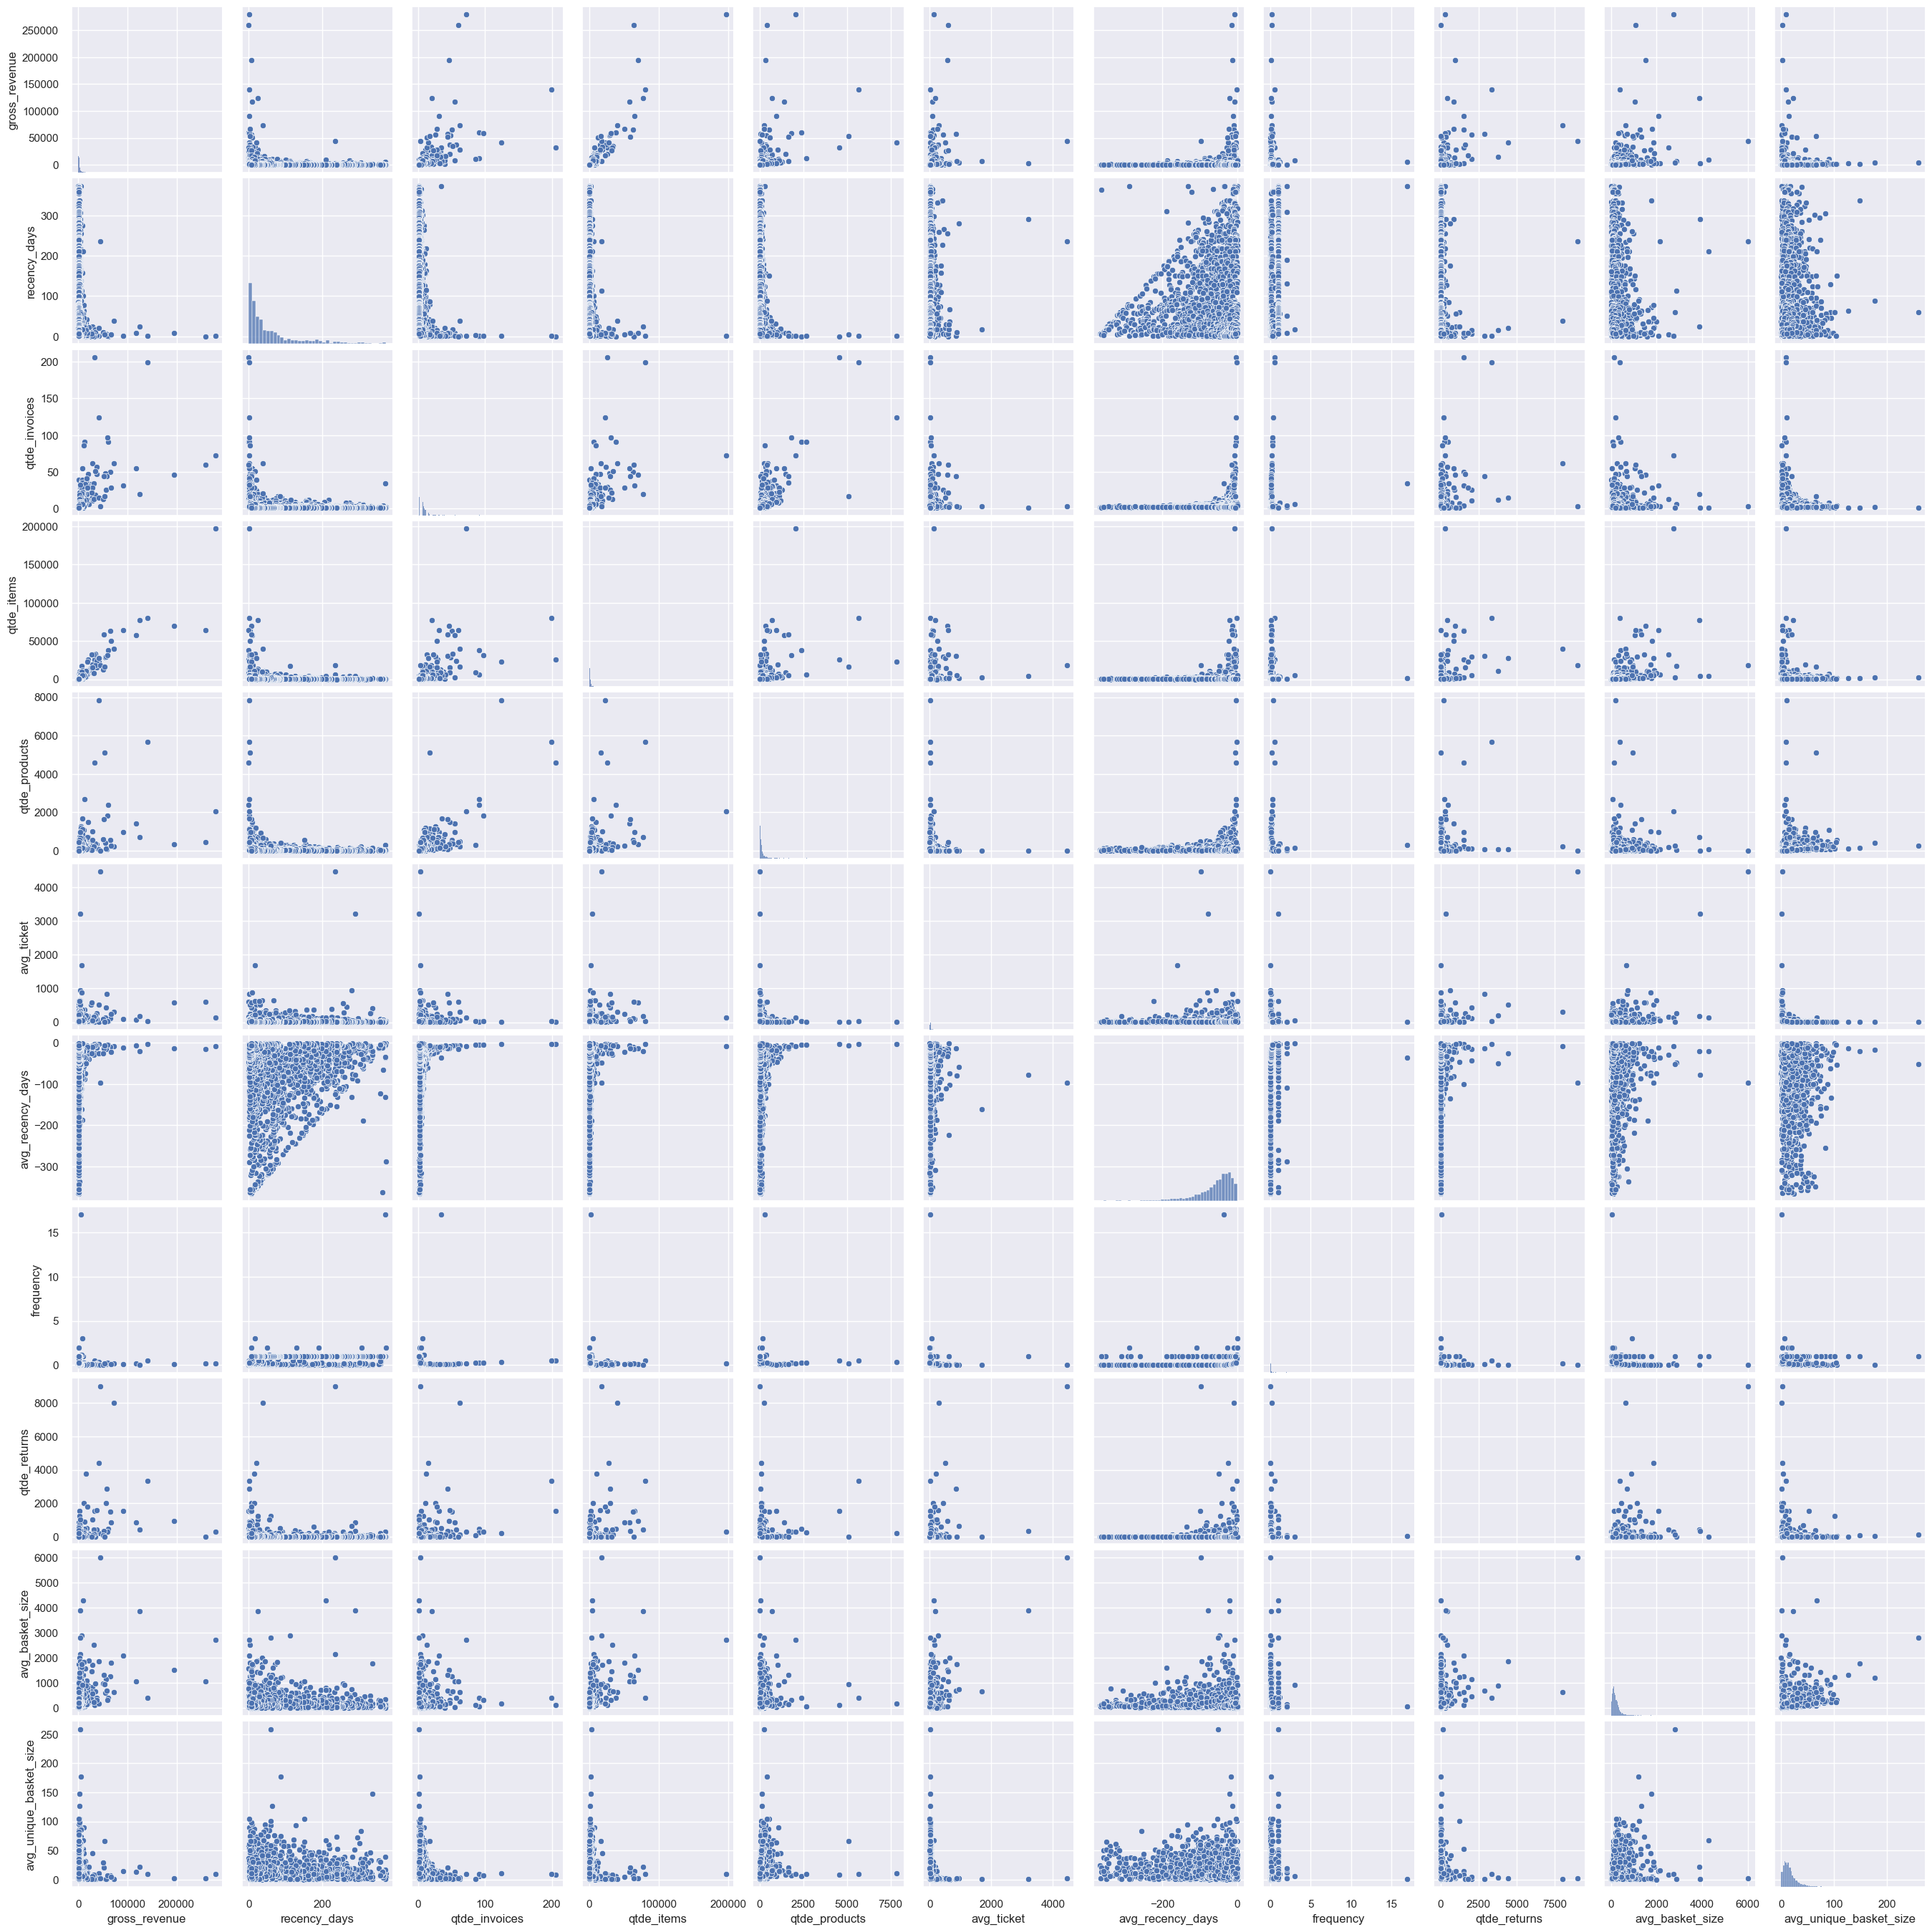

In [63]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df42 )

**Notes**
1. Frequency has low variance
2. Avg Ticket has low variance
3. qtd_products qts_invoices e qtd_items muito parecidas escolher apenas 1.

## 4.3. Estudo do Espaço

In [64]:
# original dataset
#df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy() 

In [65]:
mm = pp.MinMaxScaler()


df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])

#distribuições parecidas com qtd_products
#df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
#df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])

#Não faz sentido na analise final de cluster termos a média da média
#df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
#df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
#df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

X = df43.copy()

In [66]:
X.shape

(2968, 6)

### 4.3.1. PCA

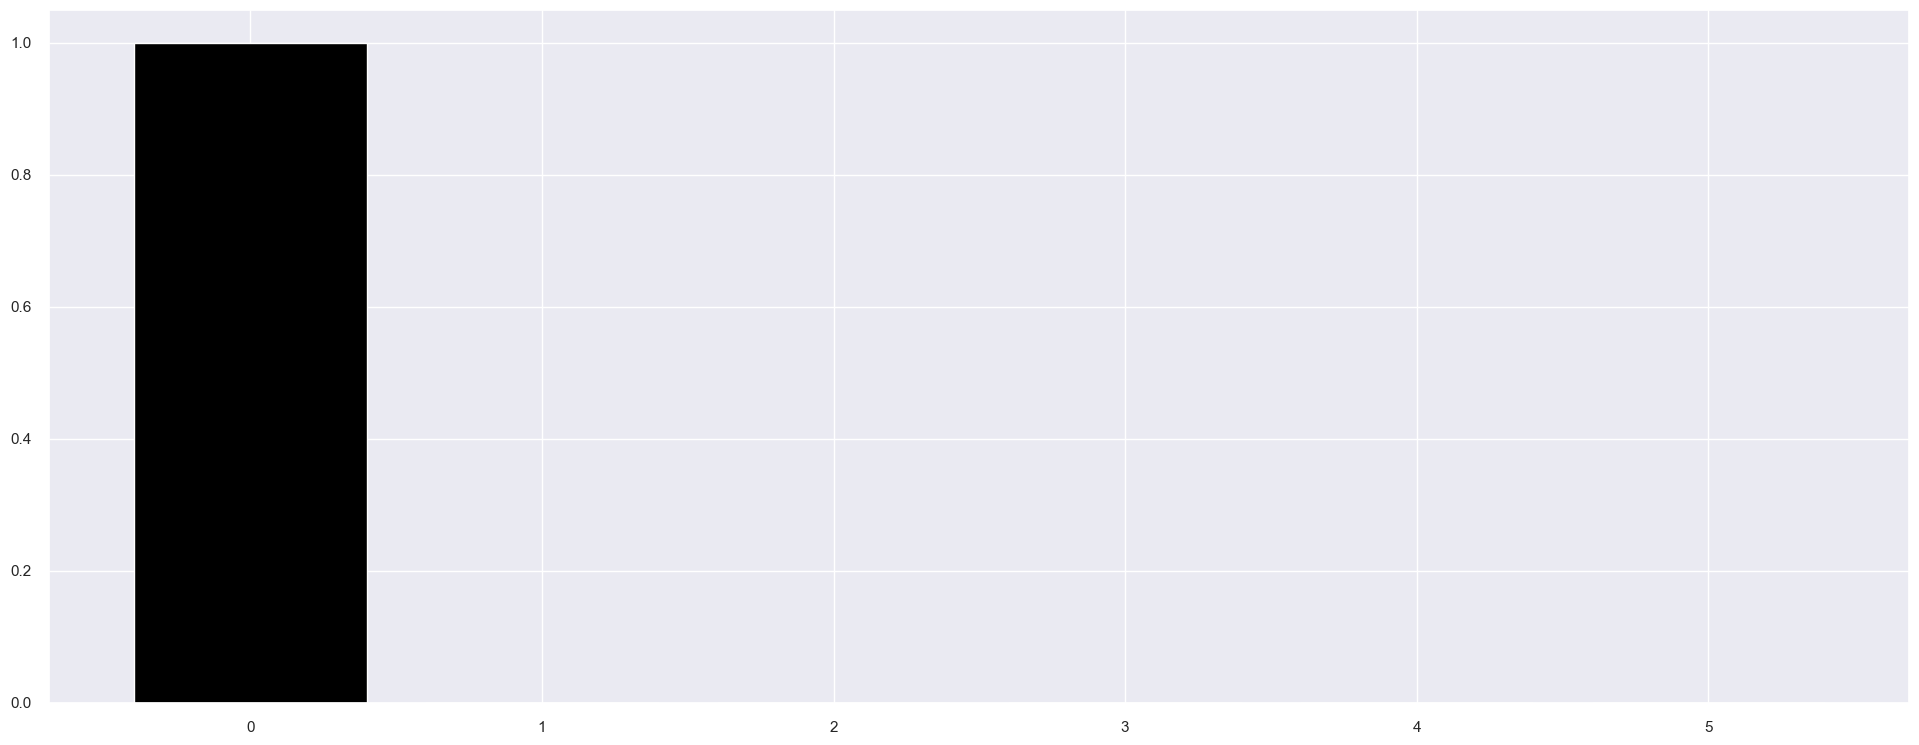

In [67]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot: xlabel='0', ylabel='1'>

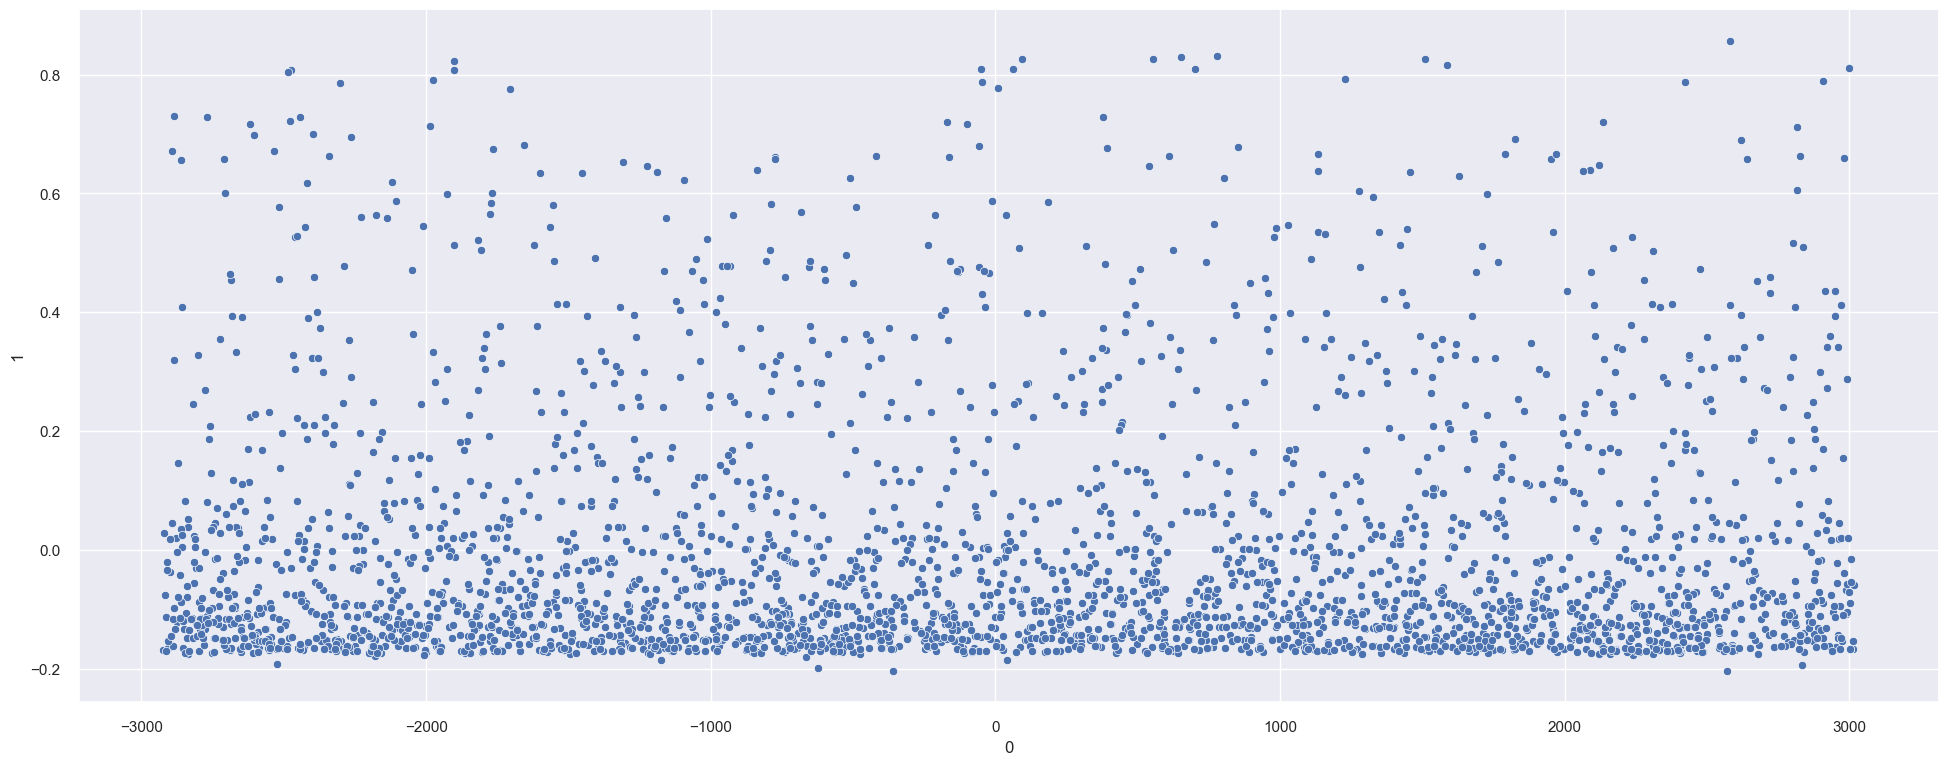

In [68]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

In [69]:
X.shape

(2968, 6)

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

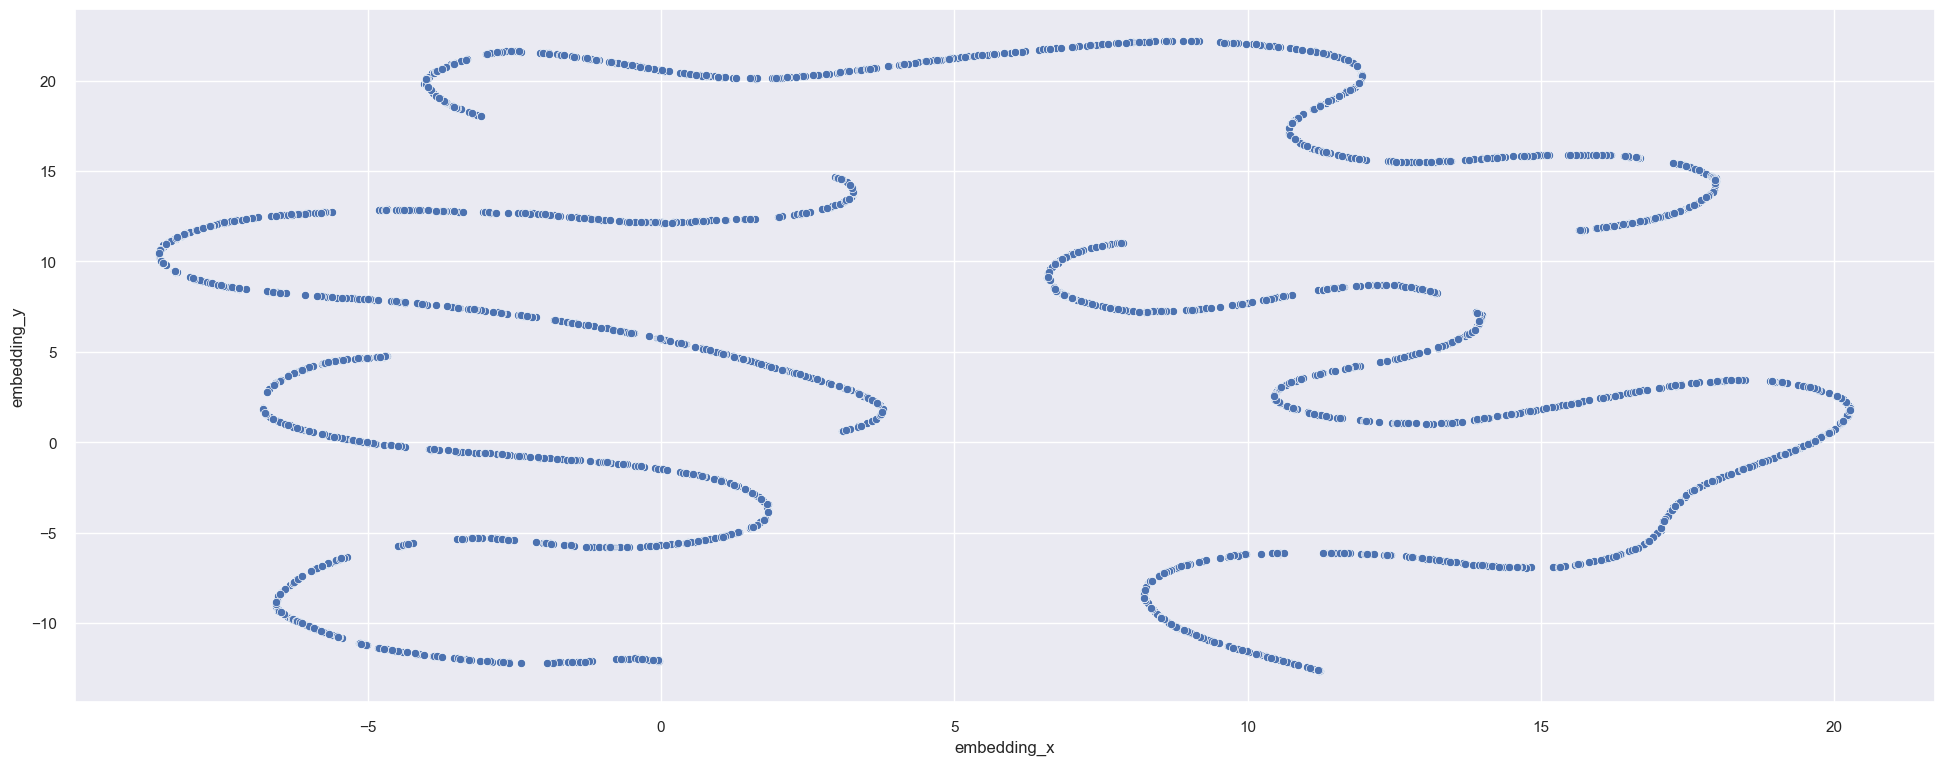

In [70]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.3. t-SNE

In [71]:
X.shape

(2968, 6)

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

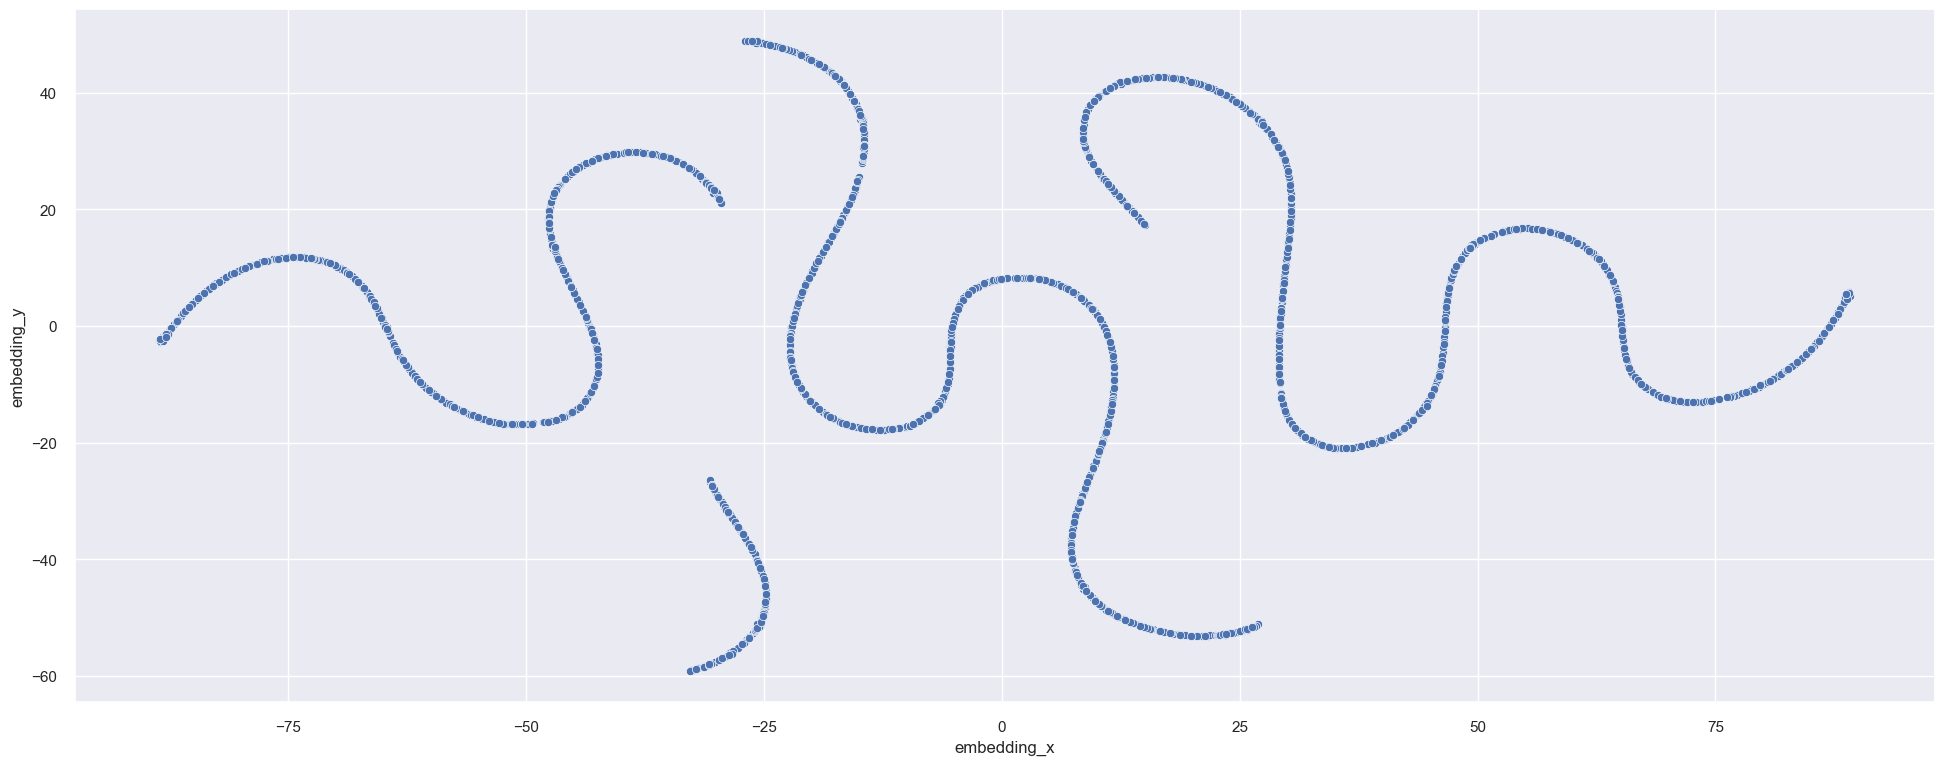

In [72]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

### 4.3.4. Tree-Based Embedding

In [73]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

RandomForestRegressor(random_state=42)

In [74]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

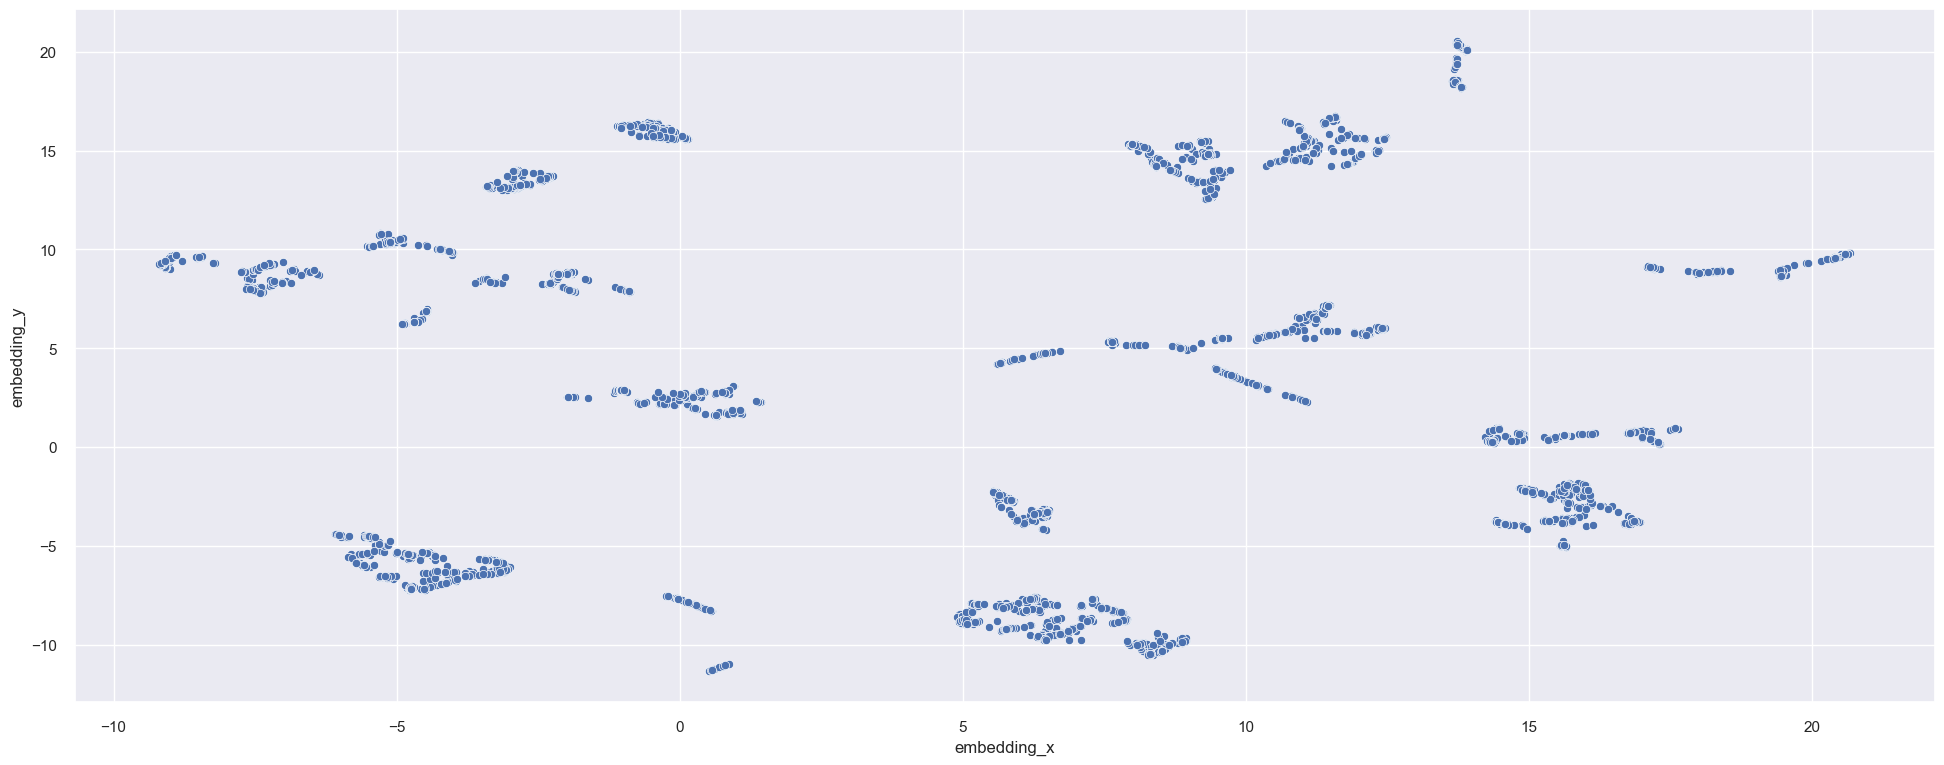

In [75]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# <font color='red'> 5.0. Data Preparation </font>

In [76]:
#Padronização/Normalizção ( Standardization ) -> Premissa de que os dados vieram de um distribuição normal
#Rescala      ( Rescale )         -> Não Premissa de que os dados vieram de um distribuição normal

**Regra do Coração**
1. Distribuiçåo Normal e não possui Outlier -> Standard Scaler - Media e desvio padrao
2. Distribuiçåo Normal e possuí Outlier -> Robust Scaler - Quartis
3. Não distribuição normal -> Min Max Scaler

In [77]:
#**Testes de Normalidade**
#QQ Plot  - Quantile Quantile Plot ( Quatile teorica x Quantile real )
#KS Teste - Kolgomorov Smirnoff ( Teste de Hipótese ) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição Normal
#

#**Detecção Outlier** 
#Box Plot -> Pontos são identificados como Outliers
#IRQ * 2.5 -> Acima desse valor ( Outlier )
#

#Z-Score > 3  -> Outilers
#Z-Score < -3 -> Outliers

In [78]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [79]:
### Standard Scaler
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()
#        
#df5['gross_revenue'] = mm_gross_revenue.fit_transform( df5[['gross_revenue']] )
#
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
#
##df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
#
##df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
#
##df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#
##df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
#
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
#
##df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# <font color='red'> 6.0. Feature Selection </font>

In [80]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [81]:
#df6 = df5[ cols_selected ].copy()
df6 = df_tree.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [82]:
#X = df6.drop( columns=['customer_id'] )
X = df_tree.copy()

In [83]:
X.head()

,embedding_x,embedding_y
0,10.918785,14.602229
1,19.531637,8.913908
2,11.945412,14.611155
3,0.142954,2.149642
4,-6.805303,9.022922


In [84]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1. K-Means

In [85]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

C:\Users\Cida\anaconda3\envs\ClusterizacaoPA5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Cida\anaconda3\envs\ClusterizacaoPA5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Cida\anaconda3\envs\ClusterizacaoPA5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Cida\anaconda3\envs\ClusterizacaoPA5\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

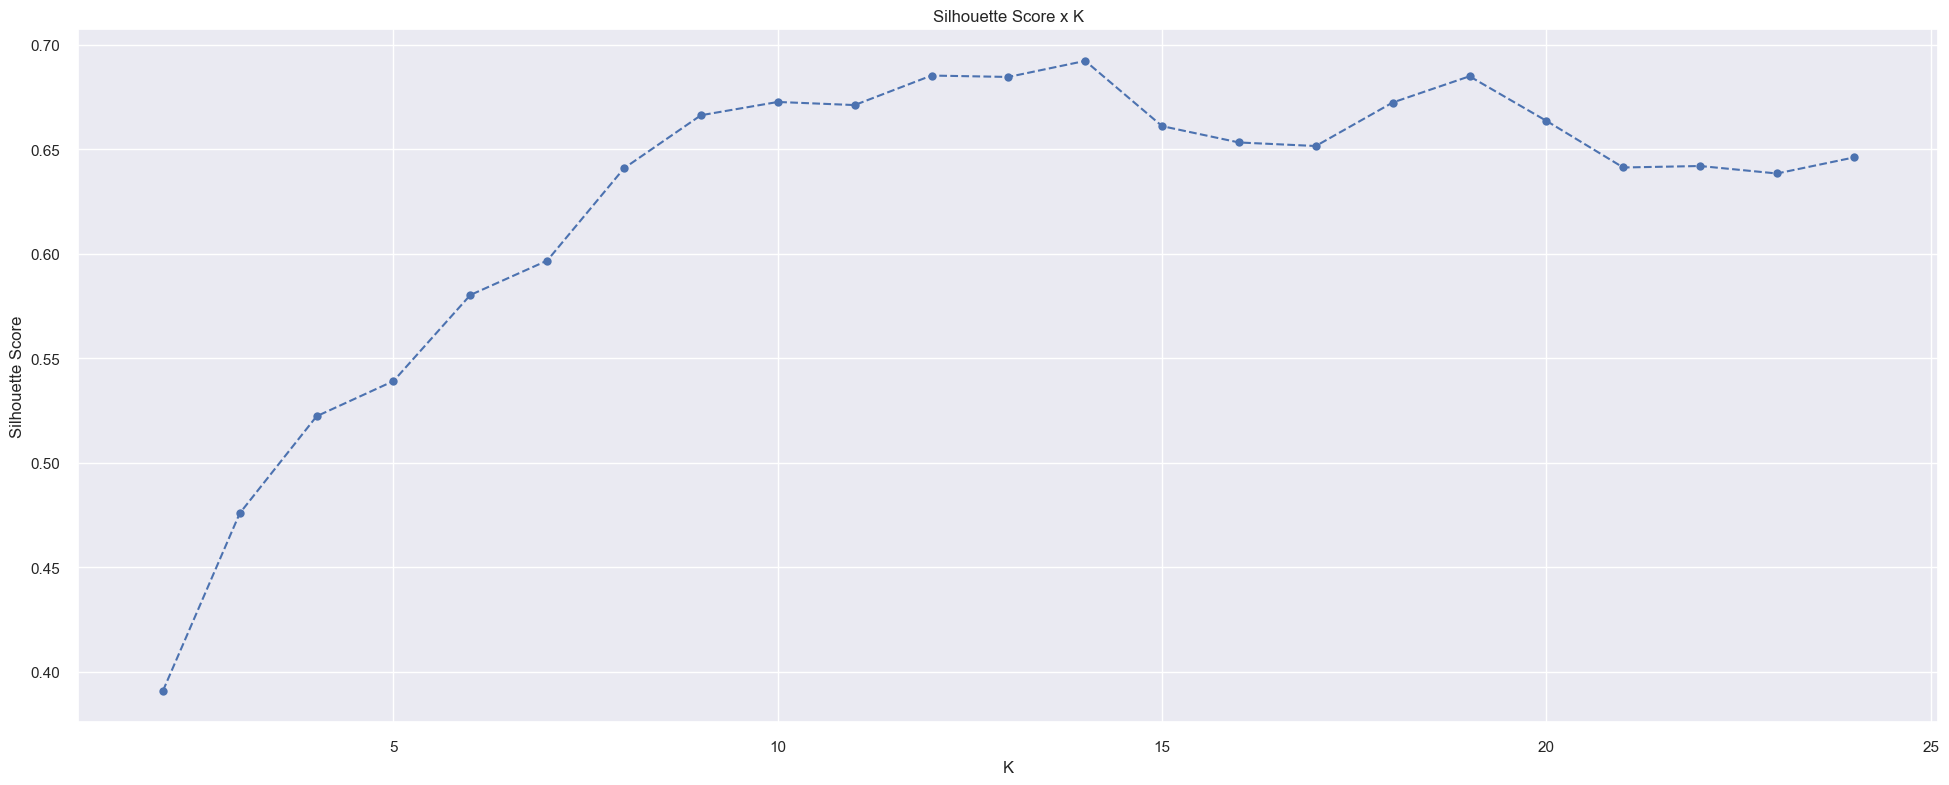

In [86]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [87]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

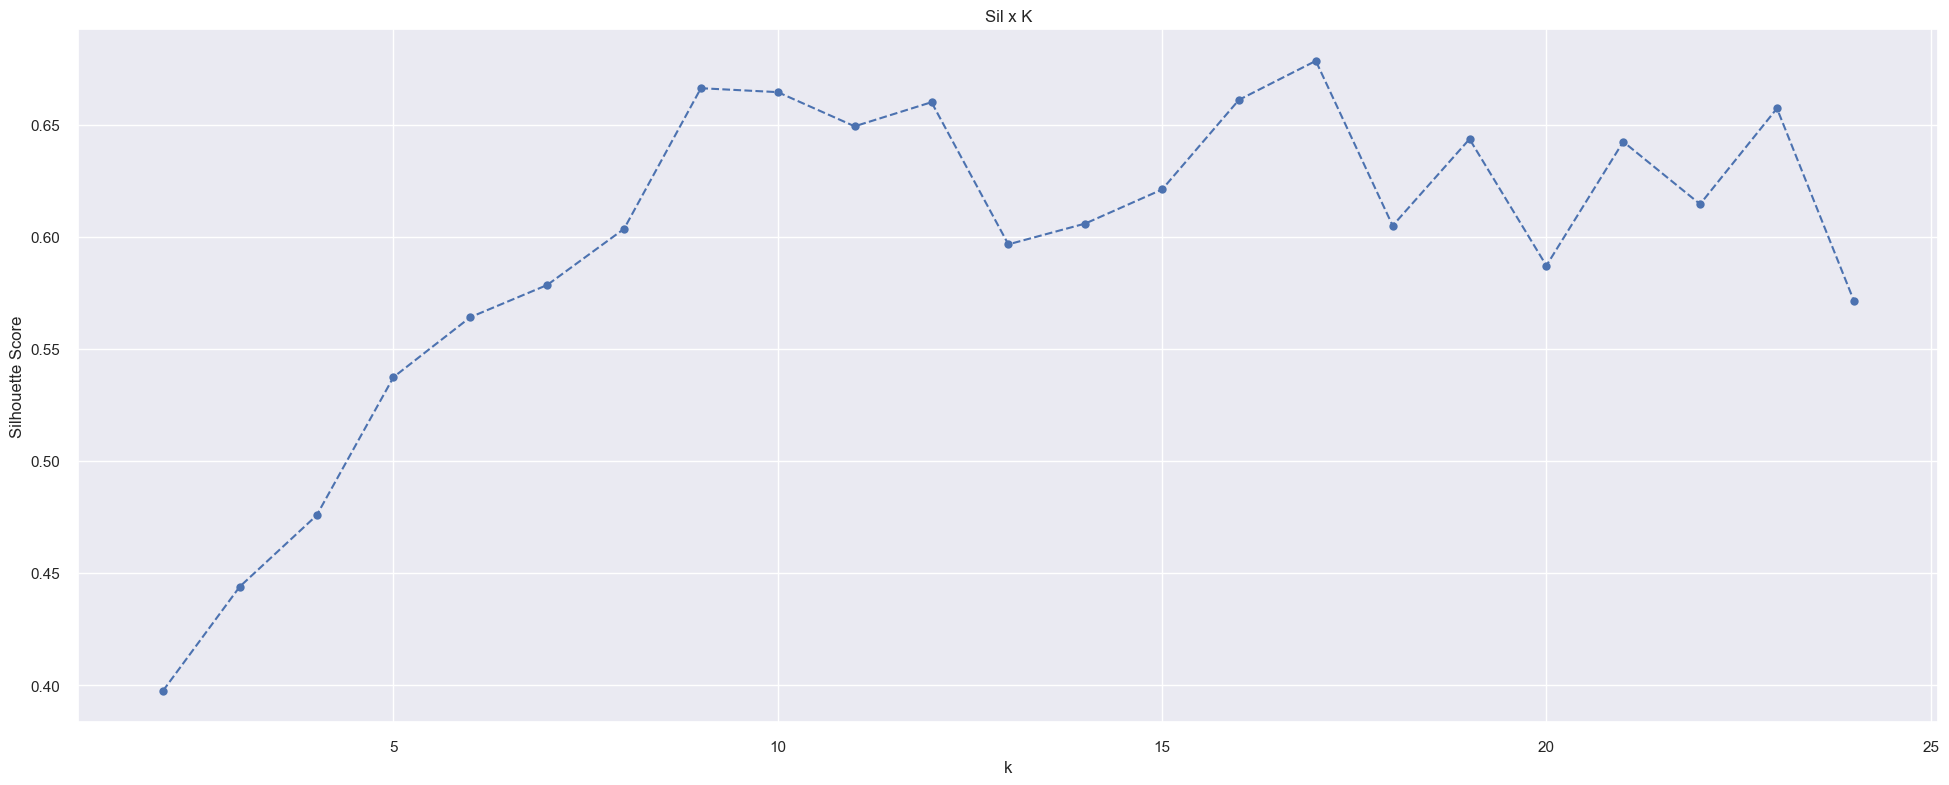

In [88]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3. Hierarchical Clustering

In [89]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

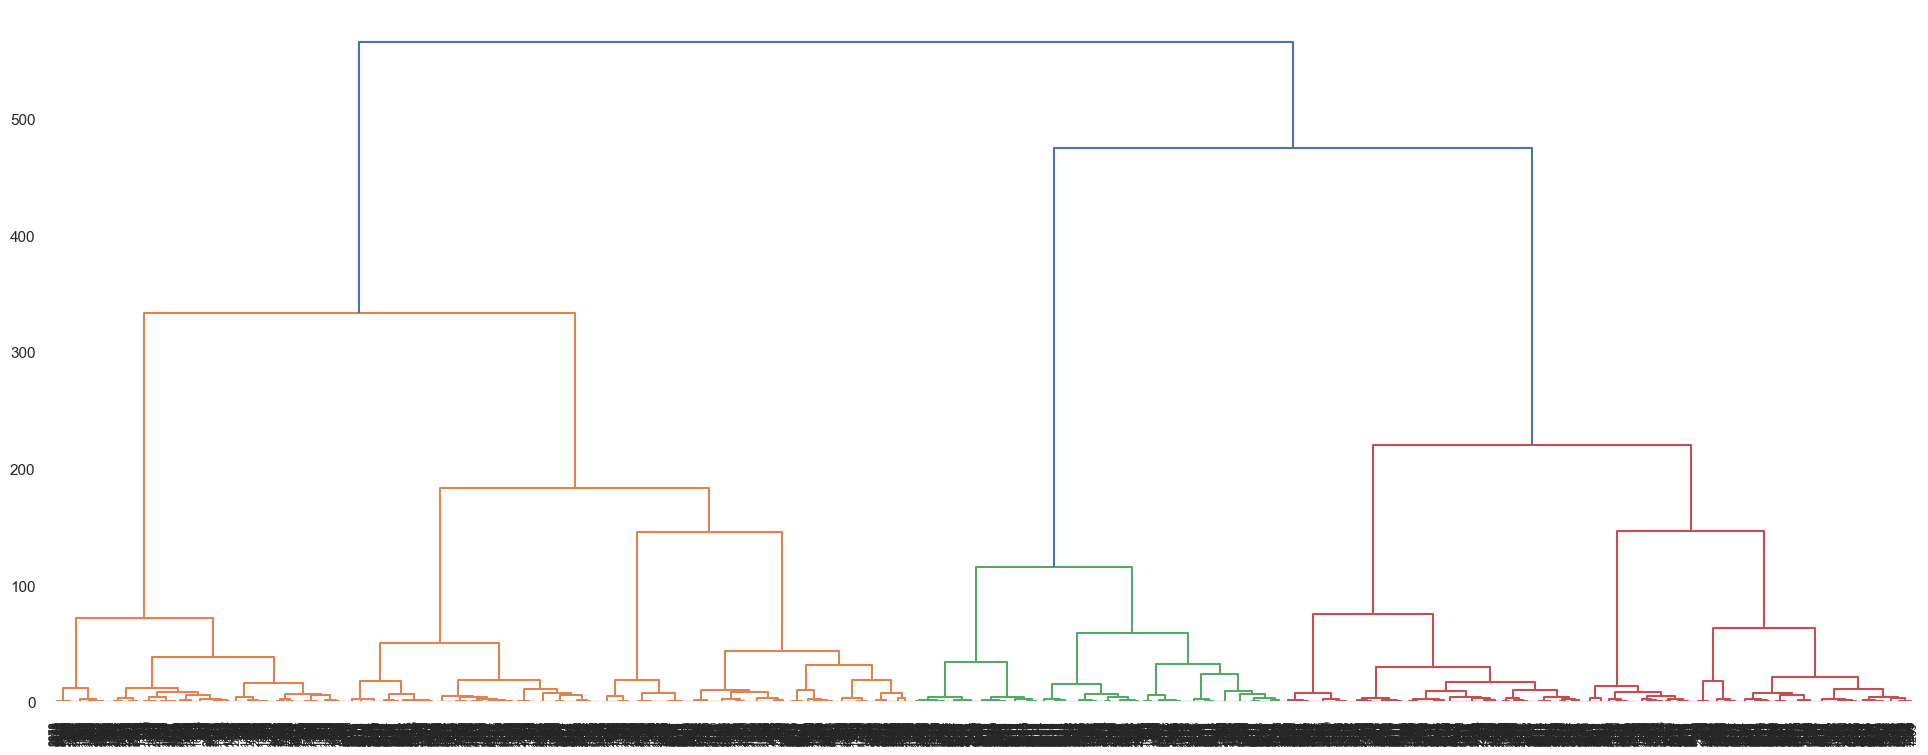

In [90]:
hc.dendrogram( 
    hc_model, 
    leaf_rotation=90,
   leaf_font_size=8
)

plt.plot()

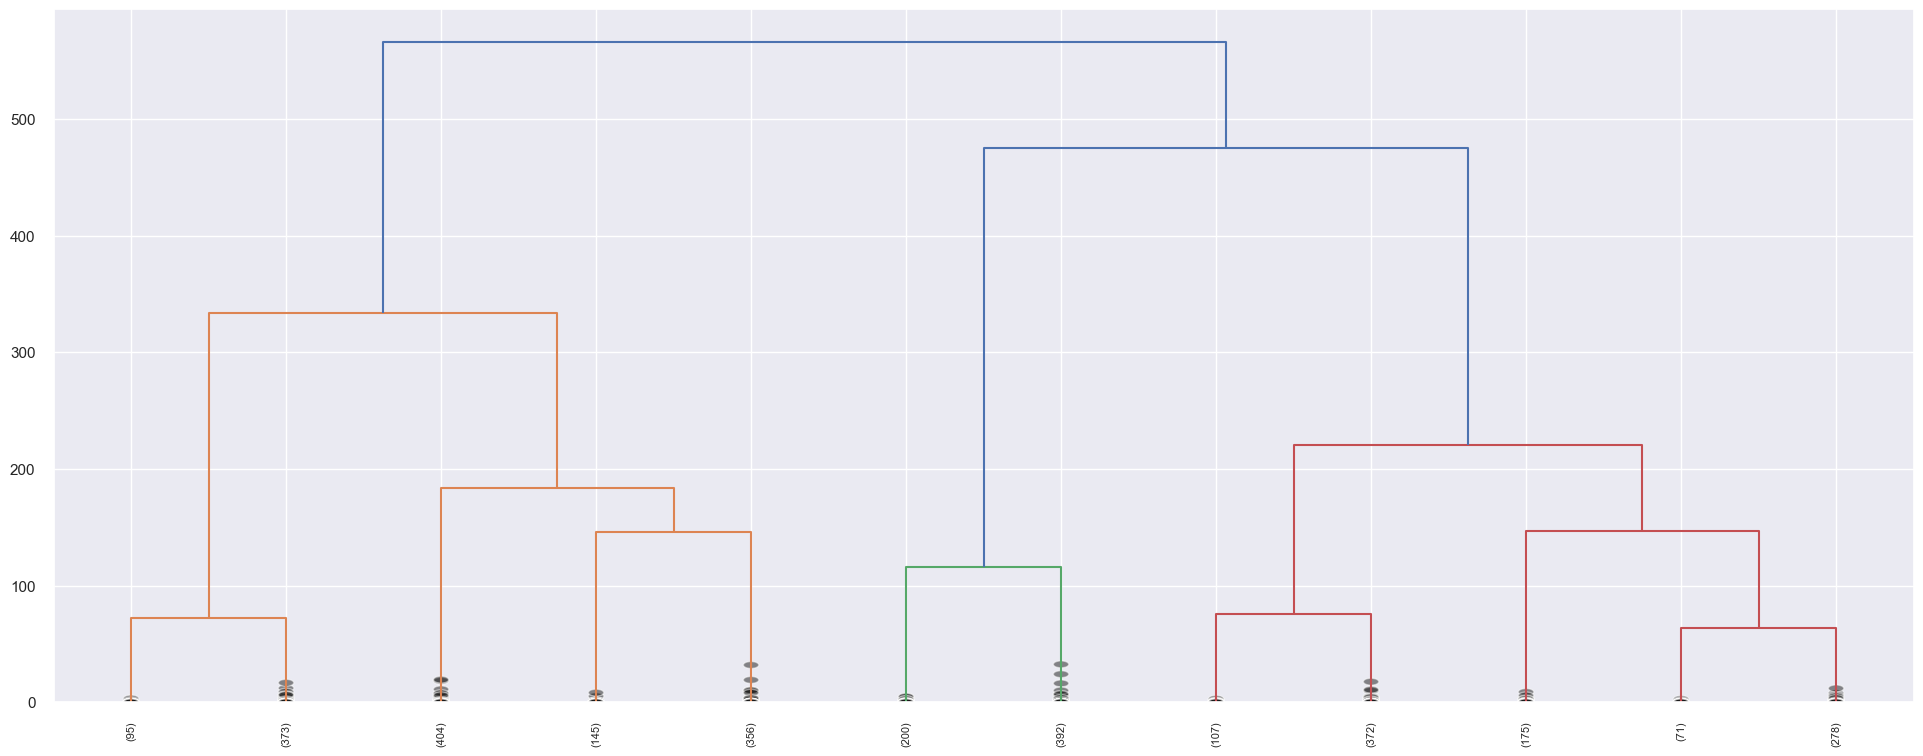

In [91]:
hc.dendrogram( 
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True
)

plt.show()

### 7.3.1. HClustering Silhouette Score

In [92]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

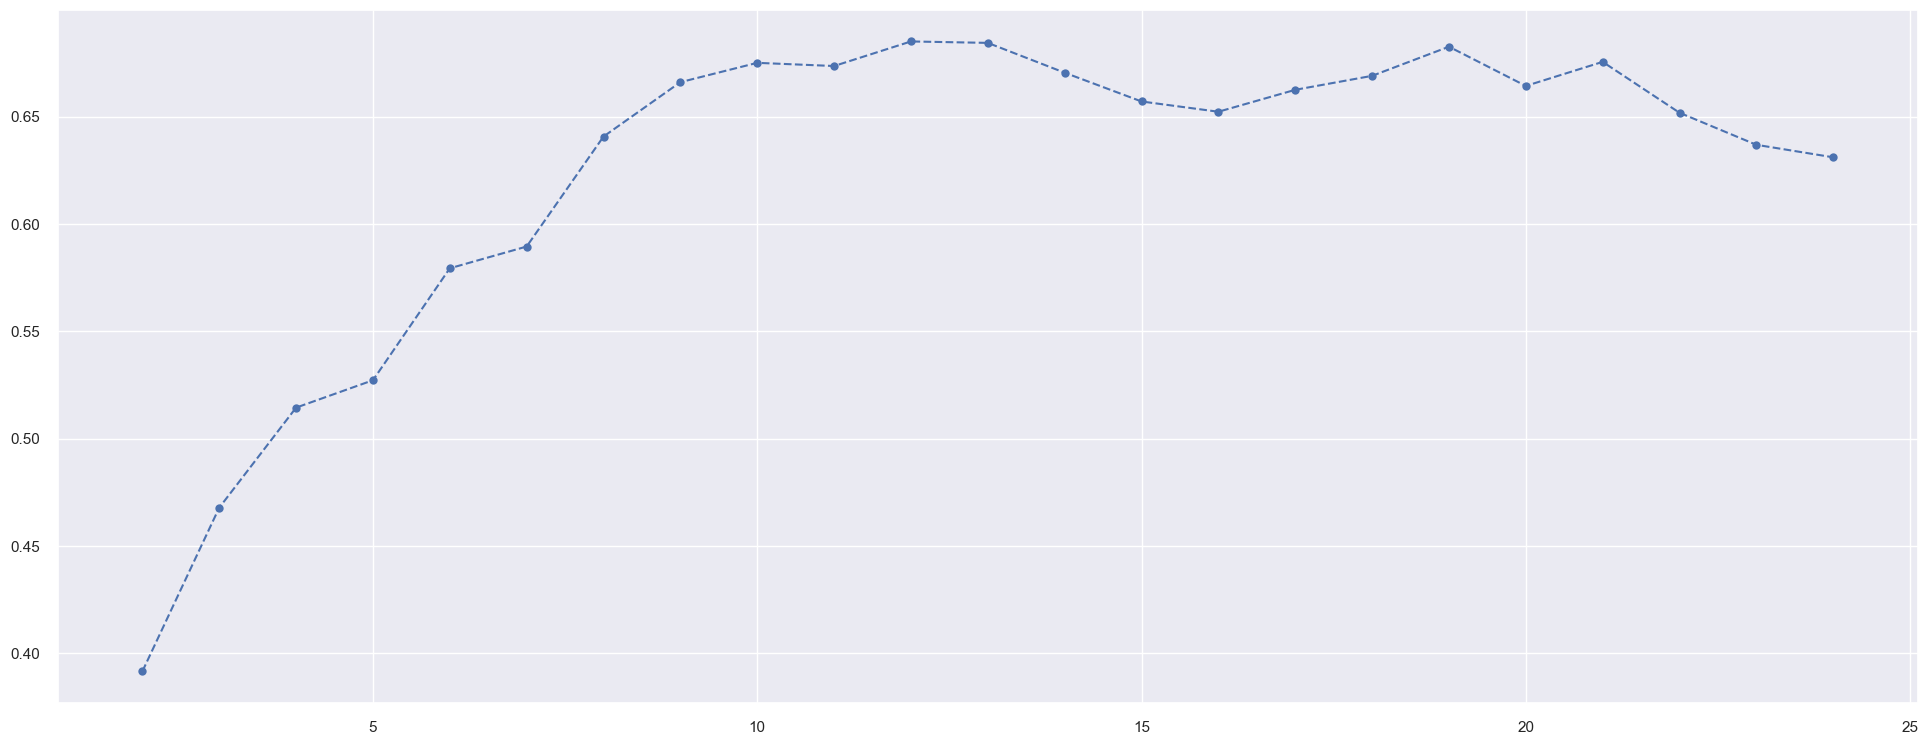

In [93]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [94]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.6644933819770813
Number of Clusters: 15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [95]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

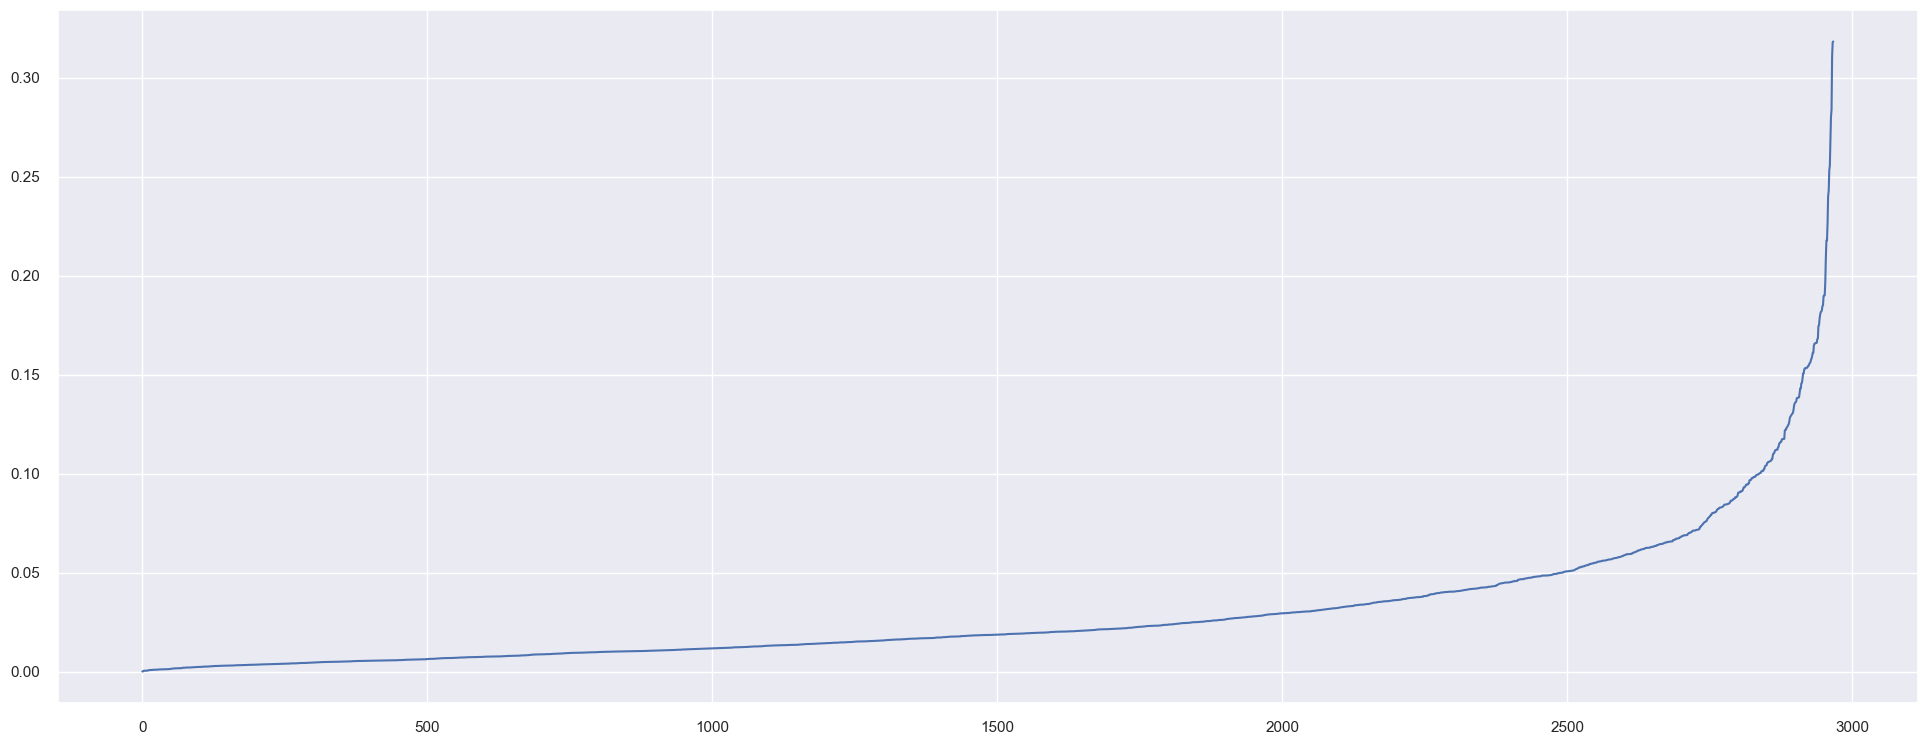

In [96]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

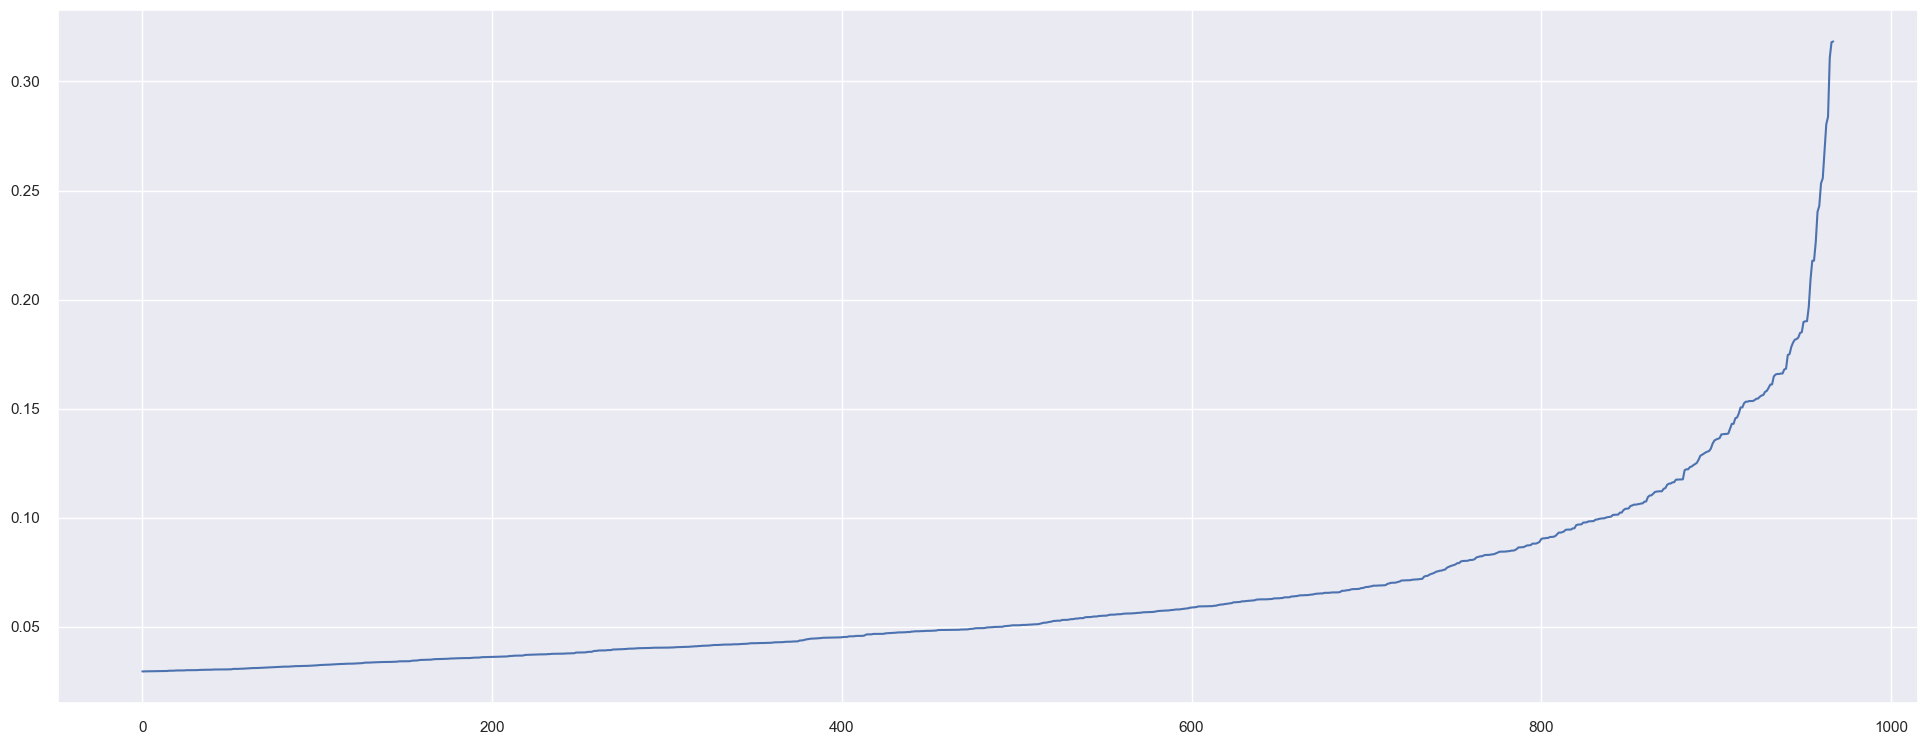

In [97]:
plt.plot( distances[2000:] )

In [98]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [99]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [100]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.390837,0.475814,0.522220,0.539043,0.580216,0.596669,0.640849,0.666204,0.672557,0.671072,0.685193,0.684523,0.692206,0.661001,0.653182,0.651488,0.672283,0.684844,0.663528,0.641210,0.641920,0.638341,0.646007
GMM,0.397412,0.443901,0.475672,0.537341,0.564082,0.578441,0.603483,0.666204,0.664458,0.649216,0.659966,0.596562,0.605841,0.621033,0.661017,0.678391,0.604893,0.643515,0.587065,0.642343,0.614497,0.657202,0.571501
HC,0.391493,0.467818,0.514478,0.527246,0.579436,0.589583,0.640849,0.666204,0.675220,0.673734,0.685193,0.684523,0.670621,0.657207,0.652420,0.662644,0.669159,0.682741,0.664447,0.675674,0.651939,0.637004,0.631178


In [101]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.390837,0.475814,0.522220,0.539043,0.580216,0.596669,0.640849,0.666204,0.672557,0.671072,0.685193,0.684523,0.692206,0.661001,0.653182,0.651488,0.672283,0.684844,0.663528,0.641210,0.641920,0.638341,0.646007
GMM,0.397412,0.443901,0.475672,0.537341,0.564082,0.578441,0.603483,0.666204,0.664458,0.649216,0.659966,0.596562,0.605841,0.621033,0.661017,0.678391,0.604893,0.643515,0.587065,0.642343,0.614497,0.657202,0.571501
HC,0.391493,0.467818,0.514478,0.527246,0.579436,0.589583,0.640849,0.666204,0.675220,0.673734,0.685193,0.684523,0.670621,0.657207,0.652420,0.662644,0.669159,0.682741,0.664447,0.675674,0.651939,0.637004,0.631178


## 7.6. Silhouette Analysis

 For K = 2. Silhouette Score: 0.39149346947669983
 For K = 3. Silhouette Score: 0.4678179919719696
 For K = 4. Silhouette Score: 0.5144777894020081
 For K = 5. Silhouette Score: 0.5272461175918579
 For K = 6. Silhouette Score: 0.5794359445571899
 For K = 7. Silhouette Score: 0.5895826816558838


IndexError: index 3 is out of bounds for axis 0 with size 3

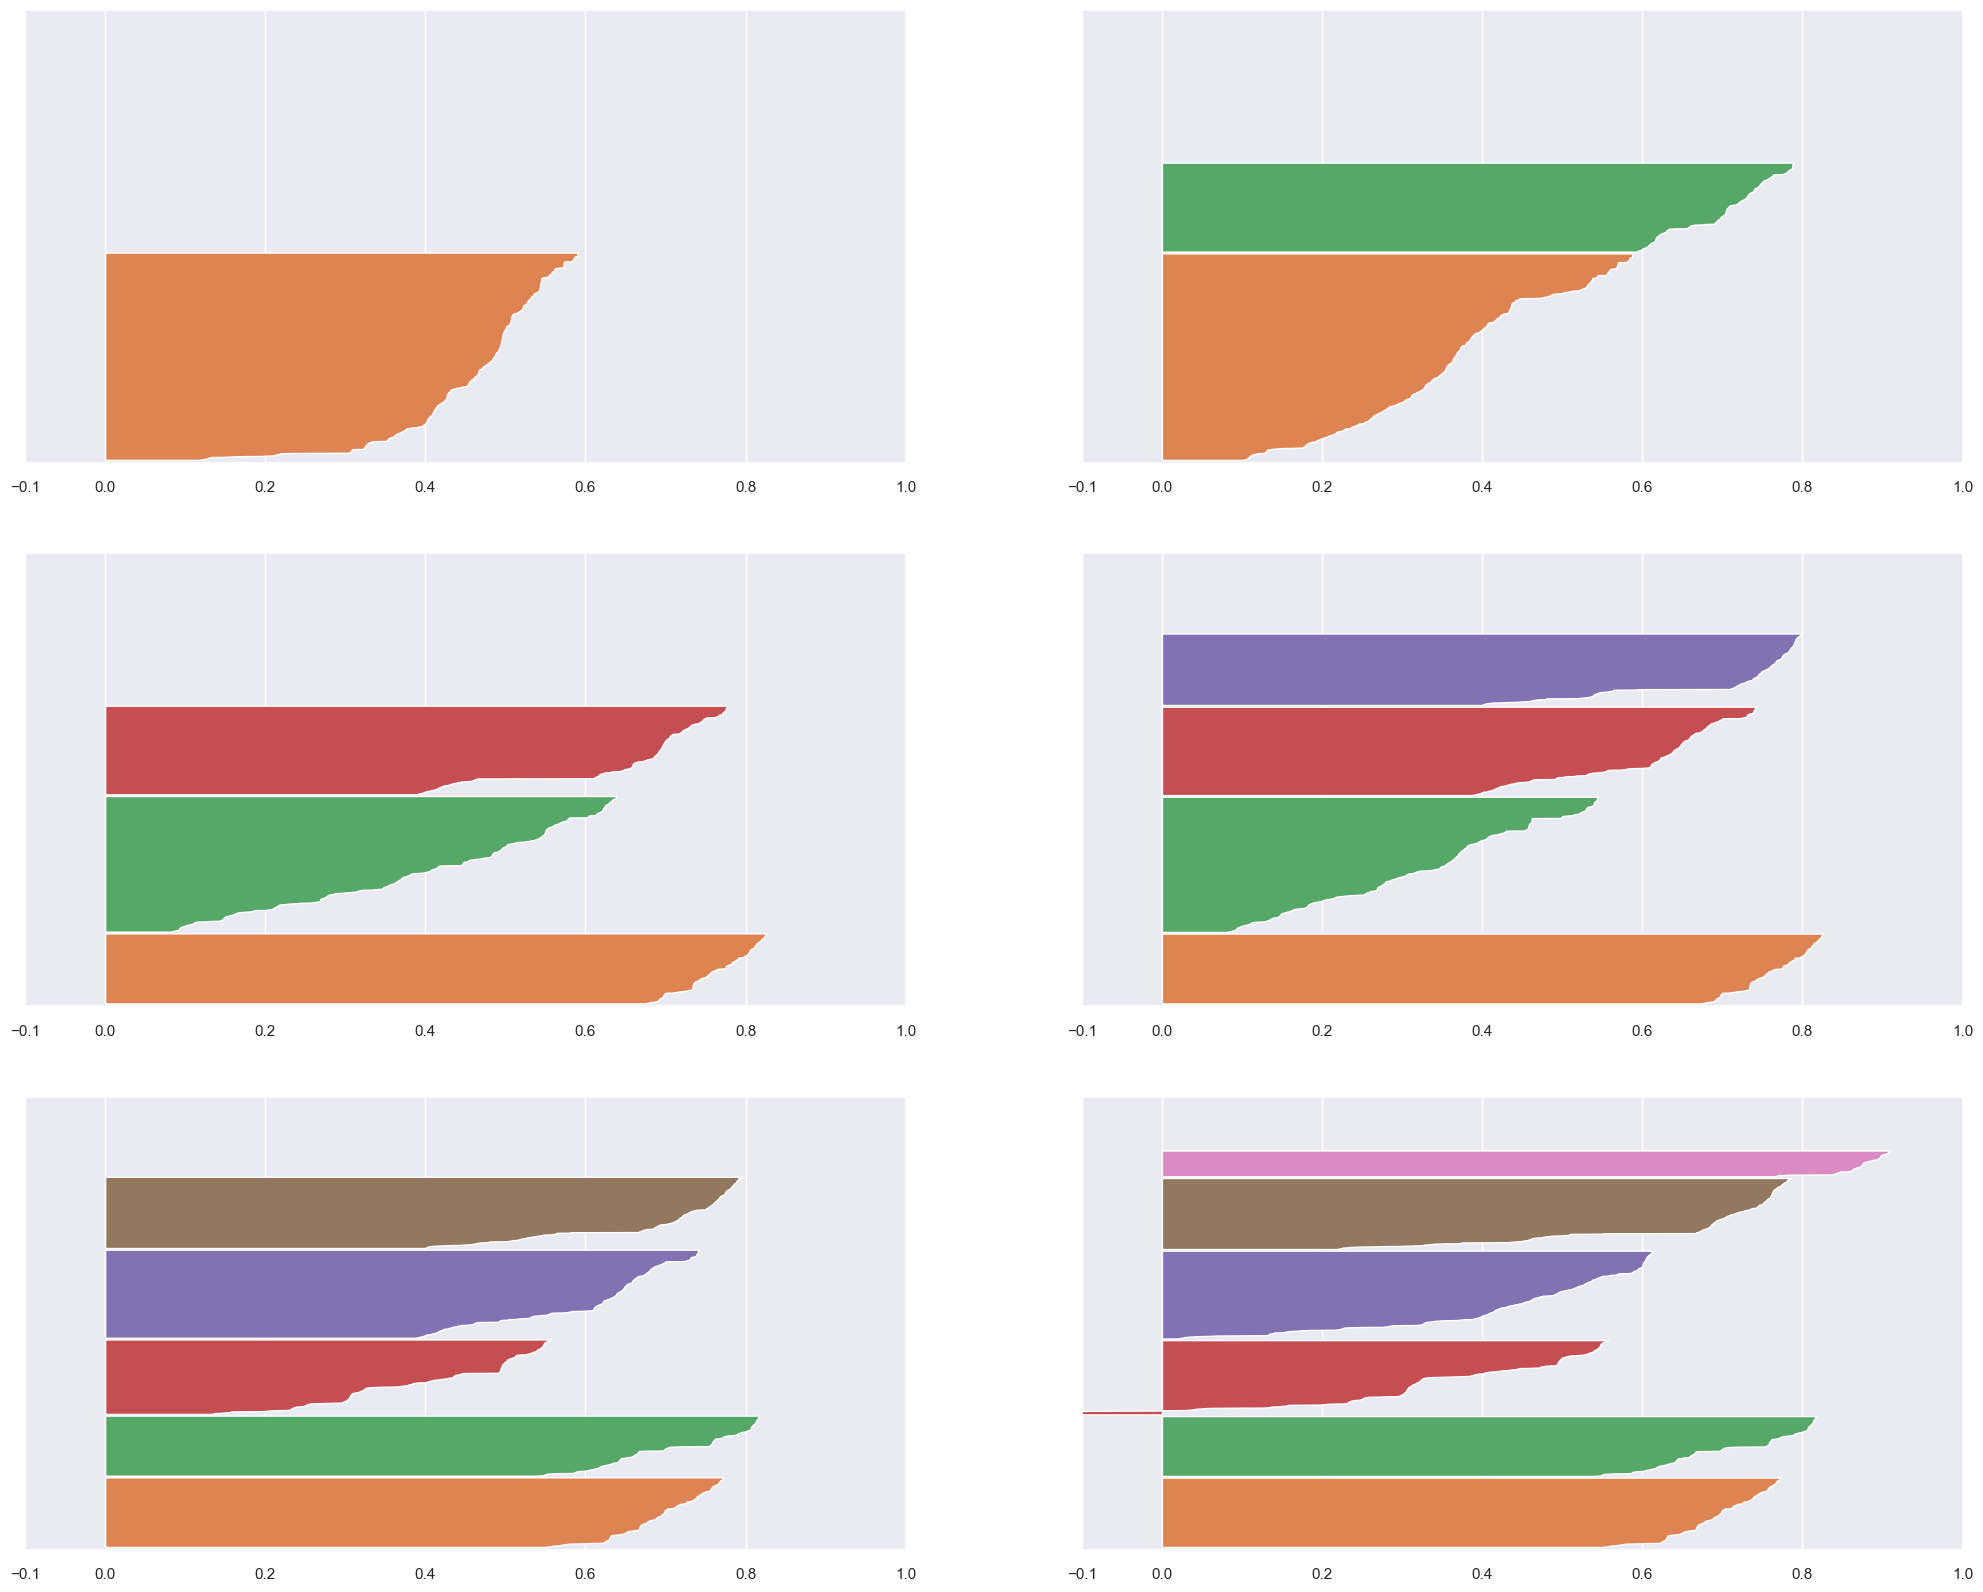

In [102]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# <font color='red'> 8.0. Model Training </font>

## 8.1. Final model

In [103]:
# model definition
k = 8
#kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=32 )
#
## model training
#kmeans.fit( X )
#
## clustering
#labels = kmeans.labels_

In [104]:
## model definition
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=32 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

In [105]:
## index of new cluster name
#idx = np.argsort( gmm_model.means_.sum( axis=1 ) )
#
## new cluster label
#new_cluster_label = np.zeros_like( idx )
#
## cluster name
#cluster_name = [10, 11, 12, 13, 14, 15, 16, 17]
#
## assigning new cluster names
#new_cluster_label[idx] = cluster_name
#labels = new_cluster_label[ labels ]

## 8.2. Cluster Validation

In [106]:
## WSS ( Within-cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.5188482403755188


# <font color='red'> 9.0. Cluster Analysis </font>

In [107]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

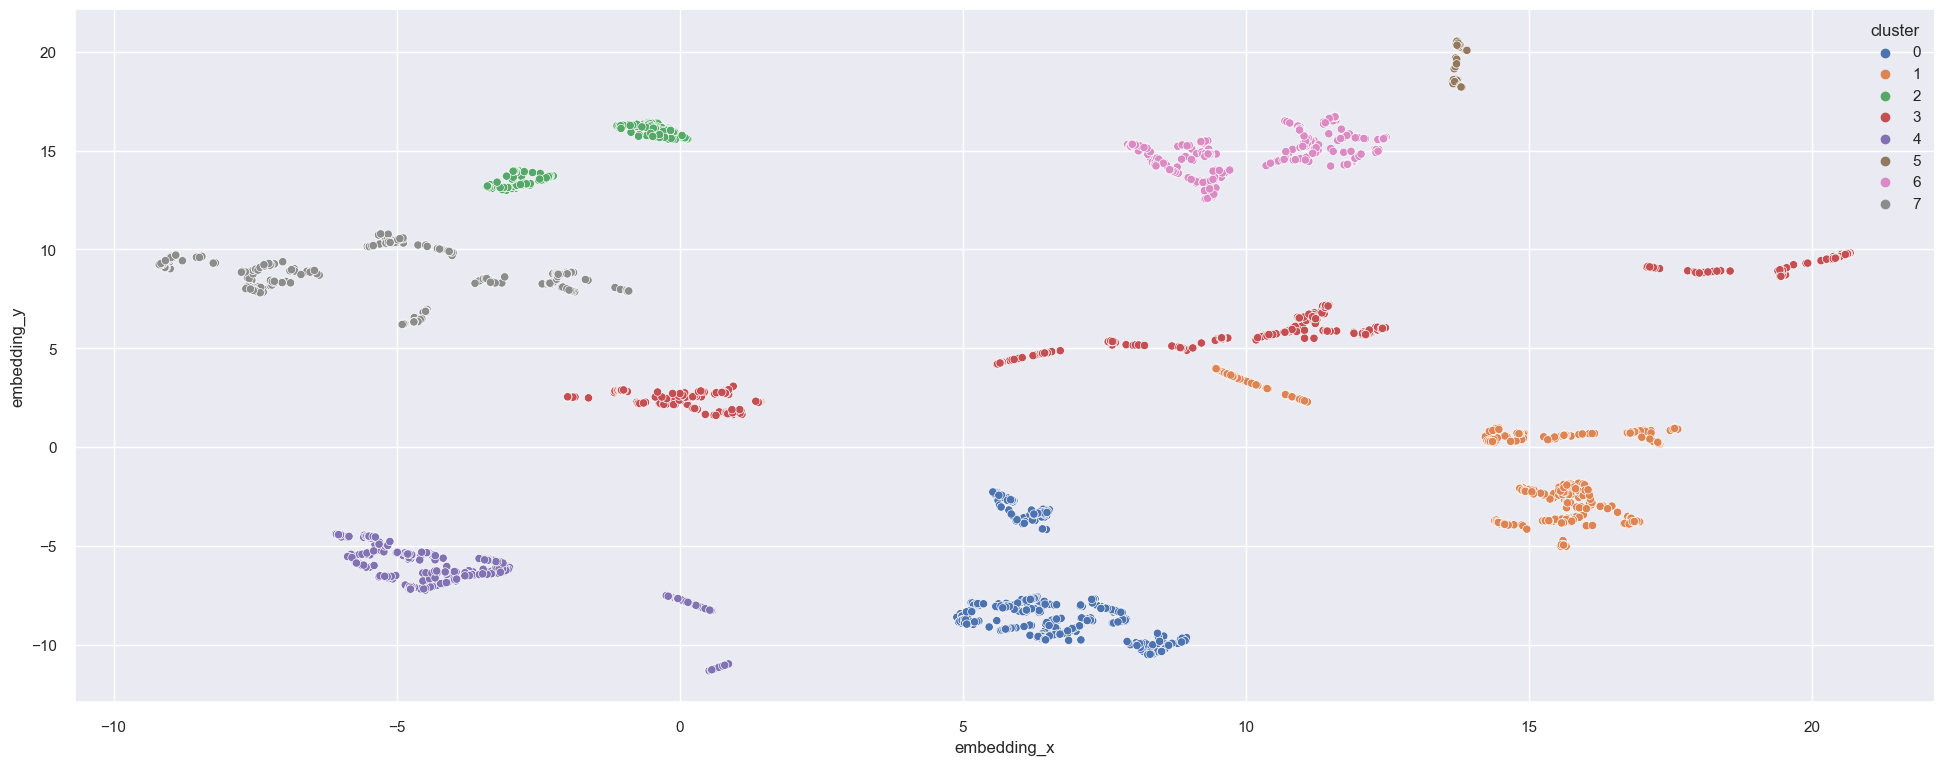

In [108]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [109]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

## 9.2. 2d plot

In [110]:
#df_viz = df9.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP


In [111]:
#reducer = umap.UMAP( n_neighbors=90, random_state=42 )
#embedding = reducer.fit_transform( X )
#
## embedding
#df_viz['embedding_x'] = embedding[:, 0]
#df_viz['embedding_y'] = embedding[:, 1]
#
## plot UMAP
#sns.scatterplot( x='embedding_x', y='embedding_y', 
#                 hue='cluster', 
#                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
#                 data=df_viz )

## 9.4. Cluster Profile

In [112]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,6
1,13047,3232.59,56.0,171.0,0.028302,35.0,3
2,12583,6705.38,2.0,232.0,0.040323,50.0,6
3,13748,948.25,95.0,28.0,0.017921,0.0,3
4,15100,876.00,333.0,3.0,0.073171,22.0,7


In [113]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
6,6,373,12.567385,10503.060483,19.268097,475.581769,0.110615,187.120643
5,5,95,3.200809,2291.266000,29.957895,222.136842,0.031576,0.663158
4,4,349,11.758760,2216.344413,69.501433,52.896848,0.072810,11.028653
3,3,592,19.946092,2083.700878,51.005068,109.479730,0.077666,19.861486
1,1,488,16.442049,1861.938012,58.532787,95.969262,0.054101,15.159836
0,0,479,16.138814,1284.840418,62.194154,57.154489,0.048812,14.225470
2,2,200,6.738544,647.933500,47.280000,11.510000,0.025991,0.845000
7,7,392,13.207547,505.728827,149.426020,15.522959,0.426596,9.443878


In [114]:
# 6 Cluster Insiders
# 5 Cluster More Products
# 4 Cluster Spend Money 
# 3 Cluster Even More Products
# 1 Cluster Less Days
# 0 Cluster Less 1k
# 2 Cluster Stop Returners
# 7 Cluster More Buy

### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 373 (12,56% do customers )
    - Recência média: 19 dias
    - Média de Produtos comprados: 475 produtos
    - Frequência de Produtos comprados: 0.11 produtos/dia
    - Receita em média: $10503 dólares
        
### Cluster 02: 
    - Número de customers: 95 (3,2 do customers )
    - Recência em média: 29 dias
    - Compras em média: 222 compras
    - Receita em média: $2291 dólares
        
### Cluster 03: 
    - Número de customers: 349 (11,78% do customers )
    - Recência em média: 92 dias
    - Compras em média: 69 compras
    - Receita em média: $2216 dólares

# <font color='red'> 10.0. Análise Exploratória de Dados </font>

In [115]:
df10 = df92.copy()

In [116]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,6
1,13047,3232.59,56.0,171.0,0.028302,35.0,3
2,12583,6705.38,2.0,232.0,0.040323,50.0,6
3,13748,948.25,95.0,28.0,0.017921,0.0,3
4,15100,876.00,333.0,3.0,0.073171,22.0,7


## 10.1. MindMap de hipoteses

1. Fenomeno
2. Entidades ( Customer, Location, Finace, Family, )
3. Caracteristicas da Entidade ( Customer=Nome, Idade, salário, escolaridade / Location=País,Cidade  / Finance=Possui investimento / Family= Qtd filhos)

## 10.2. Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

In [117]:
#Cluster | Variável para testar | Base de comparação

## Hipóteses Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes**
7. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do gmv pelos clientes insiders está concentrada no 3° quartil.**

### H1: **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
**Verdade:** O cluster insider possuem um volume de compra de produtos de 48.69%

In [118]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 6, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 48.69%


### H2. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
**Verdadeiro:** O cluster insider possuem um volume de GMV de 49.01%

In [119]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 6, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV Insiders: 49.01%


### H3. **Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes**
**Falso**: O cluster insiders tem a média de devoluções acima da média geral

In [120]:
# media de devolucao do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 6, 'qtde_returns'].mean()

# media de devolucao do total
df_avg_return_all = df10['qtde_returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 187.0 vs Avg Return All:35.0


### H4. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a  mediana do faturamento geral.**
**Verdadeiro**. A mediana do faturamento é 442.39% acima da média.

In [121]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 6, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders ) /  df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 442.39%


### H5. **A GMV dos clientes insiders esta concentrados no 3 quartil**
**Falso**. O faturamento do cluster insiders está concentrada na quartil 1

In [122]:
df_aux = df10.loc[(df10['cluster'] == 6) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];

In [123]:
np.percentile( df10.loc[df10['cluster'] == 6, 'gross_revenue'], q=0.9 )

1115.5275199999999

In [124]:
np.percentile( df10.loc[df10['cluster'] == 6, 'gross_revenue'], q=0.1 )

1053.33864

<AxesSubplot: xlabel='gross_revenue'>

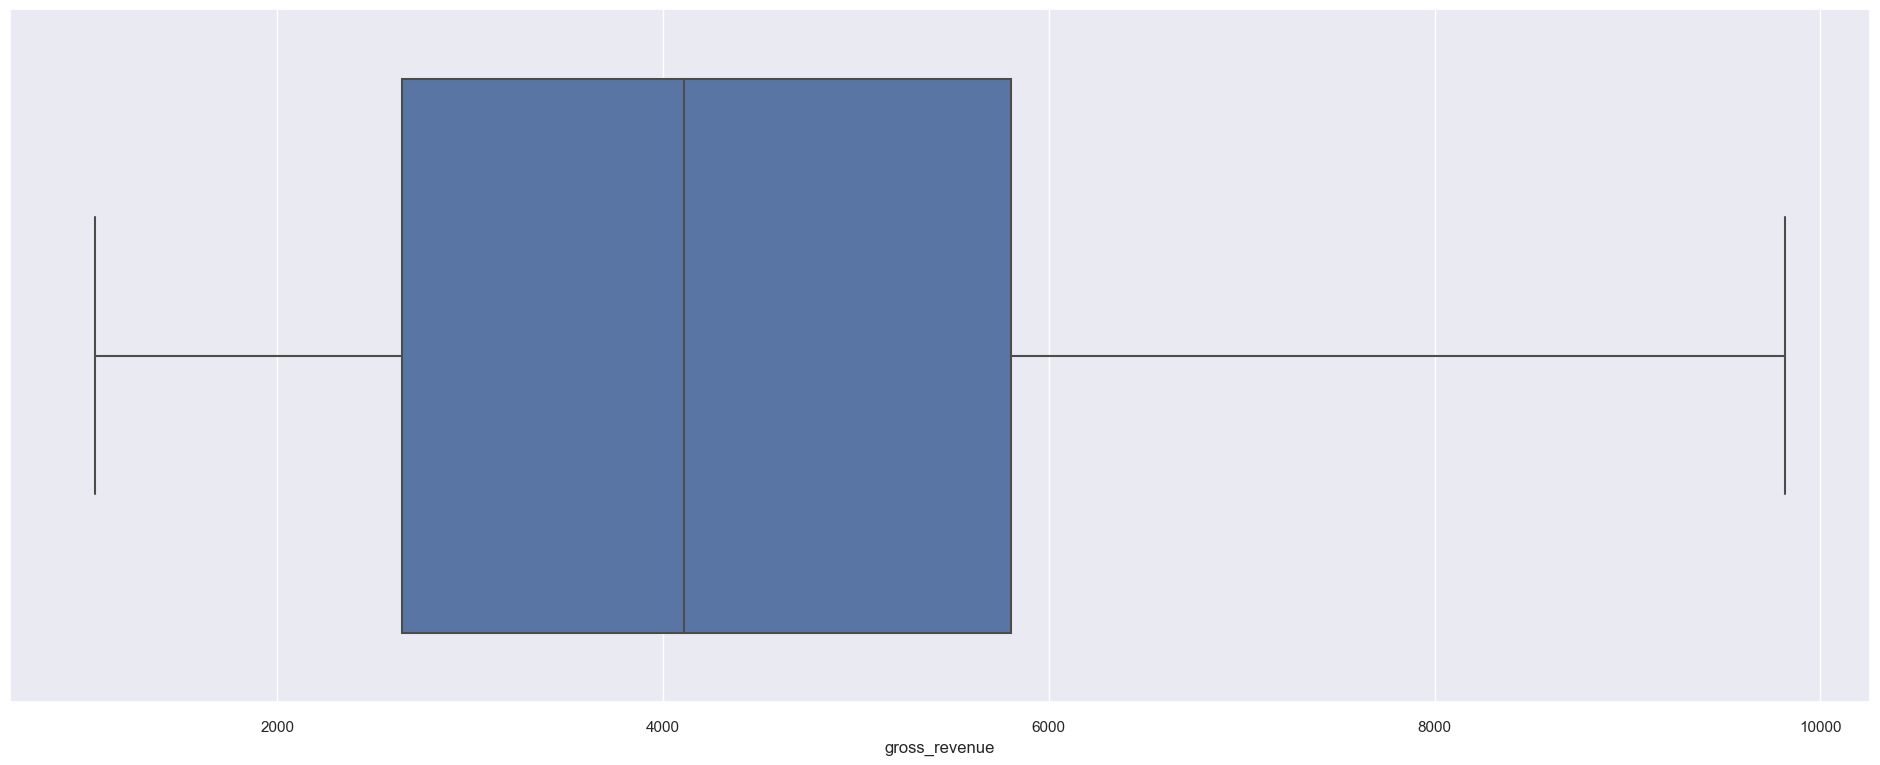

In [125]:
sns.boxplot( x=df_aux )

<AxesSubplot: xlabel='gross_revenue'>

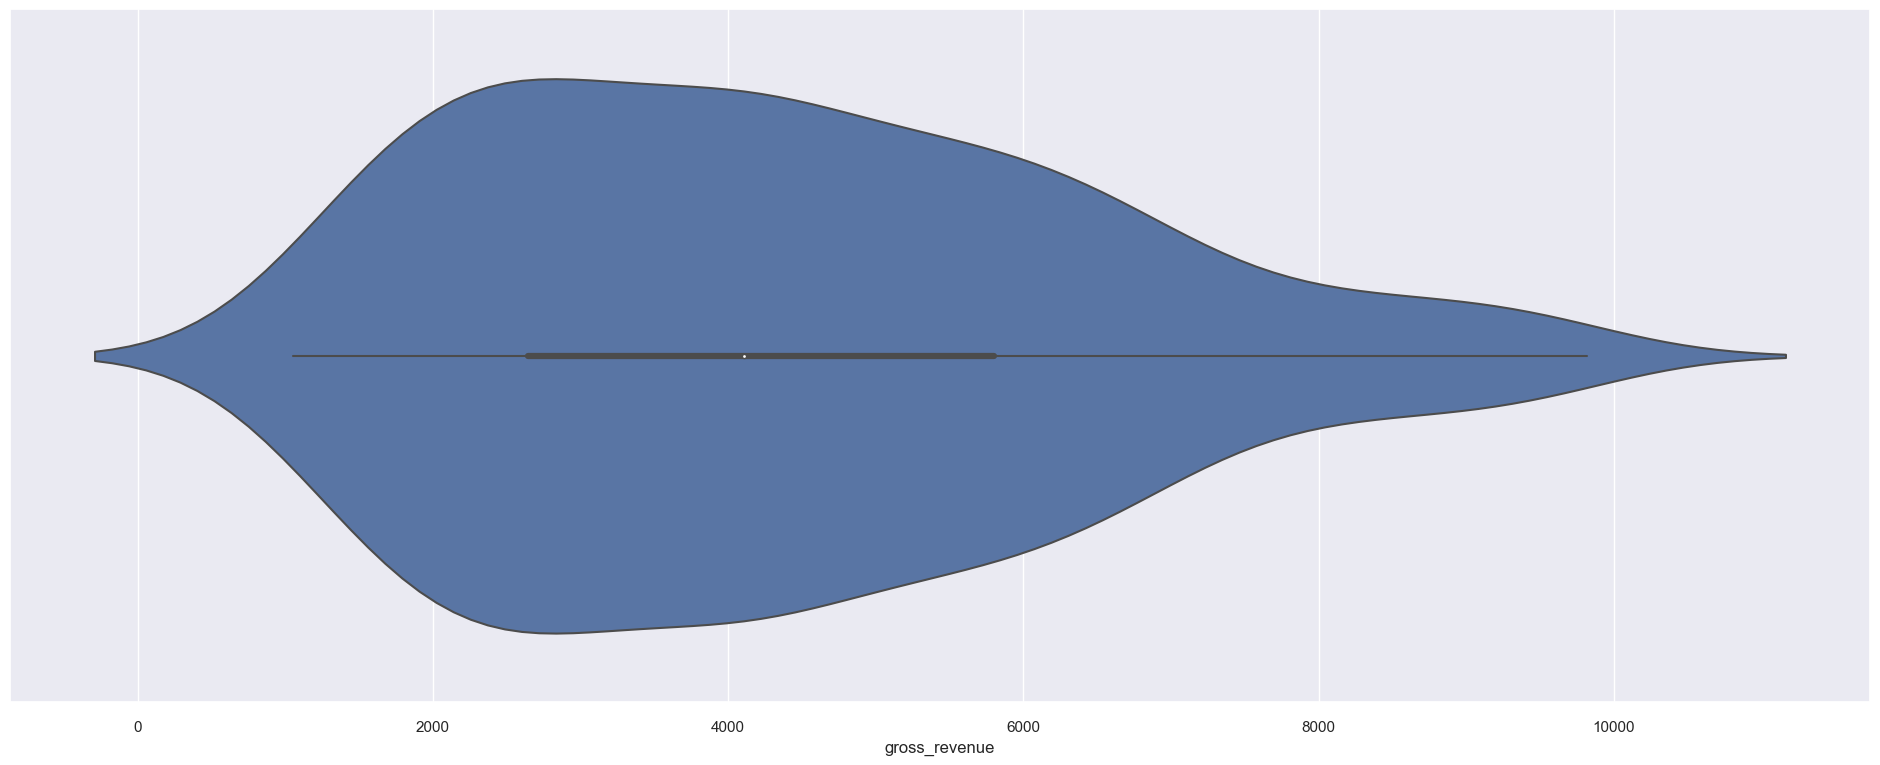

In [126]:
sns.violinplot( x=df_aux )

## Hipóteses Cliente

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4.  5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

## Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

## Quadro de Respostas Das Hipóteses

###
- H1. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**
 H1 > Verdadeira
- H2. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.**
 H2 > Verdadeira
- H3. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.**
 H3 > Falso
- H4. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.**
 H4 > Verdadeira 
- H5. **O percentil do gmv pelos clientes insiders está concentrada no 3° quartil.**
 H5 > Falso



## Perguntas de Negócio

In [127]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,6
1,13047,3232.59,56.0,171.0,0.028302,35.0,3
2,12583,6705.38,2.0,232.0,0.040323,50.0,6
3,13748,948.25,95.0,28.0,0.017921,0.0,3
4,15100,876.00,333.0,3.0,0.073171,22.0,7


### **1. Quem são as pessoas elegíveis para participar do programa de Insiders ?**

In [128]:
df10.loc[df10['cluster'] == 6, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int32

### **2. Quantos clientes farão parte do grupo?**

In [129]:
df10.loc[df10['cluster'] == 6, 'customer_id'].size

373

### **3. Quais as principais características desses clientes ?**


#### Cluster Insider
- Número de customers: 373 (12,56% do customers )
- Recência média: 19 dias
- Média de Produtos comprados: 475 produtos
- Frequência de Produtos comprados: 0.11 produtos/dia
- Receita em média: $10503 dólares

### **4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**



In [133]:
df_insiders_gmv = df10.loc[df10['cluster'] == 6, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.49005658639985367


### **5. Qual a expectativa de faturamento desse grupo para os próximos meses ?**

### **6. Quais as condições para uma pessoa ser elegível ao Insiders ?**


### **7. Quais as condições para uma pessoa ser removida do Insiders ?**


### **8. Qual a garantia que o programa Insiders é melhor que o restante da base ?**


### **9. Quais ações o time de marketing pode realizar para aumentar o faturamento?**


# <font color='red'> 11.0. Deploy To Production </font>